## Library

In [1]:
import os
import dill
import math
import random

import numpy as np
import matplotlib.pyplot as plt

import squigglepy as sq
from squigglepy import bayes
from squigglepy.numbers import K, M, B, T

from copy import copy, deepcopy
from scipy import stats
from pprint import pprint
from datetime import datetime as dt
print('Loaded 1')

exec(open('utils.py').read())
print('Loaded 2')

exec(open('modules/tai_timelines.py').read())
print('Loaded TAI timelines module')


Loaded 1
Loaded 2
Loaded TAI timelines module


## Variables

In [2]:
# Global variables - probably don't want to change these but you could.
RUNS = 1000                                       # Number of runs to do (default 10000)
CURRENT_YEAR = 2023                               # What year to start the run on? (default: 2023)
MAX_YEAR = CURRENT_YEAR + 10_000                  # What year to end the run on? (default: 2123)
years = list(range(CURRENT_YEAR, MAX_YEAR))

In [3]:
tai_flop_size = sq.sample(load_cache_file='caches/pasta')  # Cache generated in "Anchors" notebook
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/pasta.sqcache.npy'))))
tai_flop_size = [round(t, 1) for t in tai_flop_size]
sq.get_percentiles(tai_flop_size)

Cache from: 2023-07-09 16:08:13.276039


{1: 23.4,
 5: 24.7,
 10: 25.4,
 20: 26.3,
 30: 27.1,
 40: 27.9,
 50: 29.4,
 60: 31.1,
 70: 33.1,
 80: 35.5,
 90: 38.9,
 95: 41.7,
 99: 47.301000000000016}

In [4]:
initial_pay = sq.sample(load_cache_file='caches/initial_pay')  # Cache generated in "Initial pay" notebook
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/initial_pay.sqcache.npy'))))
initial_pay = [round(p, 1) for p in initial_pay]
# TODO: Suspicious this is not working in the model correctly
sq.get_percentiles(initial_pay)

Cache from: 2023-07-09 16:15:00.888206


{1: 8.0,
 5: 8.2,
 10: 8.3,
 20: 8.4,
 30: 8.5,
 40: 8.6,
 50: 8.7,
 60: 8.7,
 70: 8.8,
 80: 8.9,
 90: 9.1,
 95: 9.2,
 99: 9.6}

In [5]:
# PROBABILITY OF A NONSCALING DELAY

# set to None to have no delay
# Otherwise specified in a dictionary
# {'delay': {'prob': <array of probabilities by year>, 'length': <distribution to sample from to get length of delay>}}

# Cache defined in "(3B) Nonscaling Delay Curve"

with open('caches/nonscaling_delays.dill', 'rb') as f:
    delay = dill.load(f)
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/nonscaling_delays.dill'))))

delay

Cache from: 2023-07-09 16:18:48.170215


{'algorithms': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=4.37, lognorm_sd=1.93, norm_mean=1.39, norm_sd=0.42)
   - 0.1 weight on <Distribution> lognorm(lognorm_mean=12.12, lognorm_sd=9.64, norm_mean=2.25, norm_sd=0.7)},
 'infra': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=3.45, lognorm_sd=2.42, norm_mean=1.04, norm_sd=0.63)
   - 0.1 weight on <Distribution> lognorm(lognorm_mean=12.12, lognorm_sd=9.64, norm_mean=2.25, norm_sd=0.7)},
 'data': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=3.45, lognorm_sd=2.42, norm_mean=1.04, norm_sd=0.63)
   - 0.1 weight on <Distribution> l

In [6]:
def wildeford_max_gdp_frac():
    small_project = sq.lognorm(1 / (4*K), 1 / (1*K))
    modern_megaproject = sq.lognorm(1/K, 1/600)
    old_form_megaproject = sq.lognorm(1/K, 1/150)
    gigaproject = sq.lognorm(1/150, 1/50)
    
    r_ = random.random()
    if r_ < 0.1:
        gdp_frac = small_project
        percent_spent_on_compute = sq.lognorm(0.5, 0.95, lclip=0.1, rclip=0.999)
    elif r_ < 0.7:
        gdp_frac = modern_megaproject
        percent_spent_on_compute = sq.lognorm(0.7, 0.95, lclip=0.1, rclip=0.999)
    elif r_ < 0.9:
        gdp_frac = old_form_megaproject
        percent_spent_on_compute = sq.lognorm(0.85, 0.95, lclip=0.1, rclip=0.999)
    else:
        gdp_frac = gigaproject
        percent_spent_on_compute = sq.lognorm(0.85, 0.99, lclip=0.1, rclip=0.999)
        
    models_trained_per_year_for_budget = sq.lognorm(1, 10)

    frac = ~gdp_frac * ~percent_spent_on_compute / ~models_trained_per_year_for_budget
    
    return (1 / (4*K)) if frac < (1 / (4*K)) else frac


variables = {'initial_gdp': 23*T,
             'tai_flop_size': tai_flop_size,
             'algo_doubling_rate_max': 3,
             'algo_doubling_rate_min': 1,
             'min_reduction': 2,
             'max_reduction': sq.lognorm(3, 15),
             'initial_flop_per_dollar': 18.3,
             'flop_halving_rate': sq.norm(1.5, 3.5),     # https://epochai.org/blog/predicting-gpu-performance
             'max_flop_per_dollar': sq.lognorm(21, 26),  # https://epochai.org/blog/predicting-gpu-performance and https://asteriskmag.com/issues/03/the-transistor-cliff
             'initial_pay': initial_pay,
             'gdp_growth': sq.lognorm(1.01, 1.035, lclip=1.005),
             'max_gdp_frac': wildeford_max_gdp_frac, # TODO: Willingness to spend connected to commercialization
             'spend_doubling_time': sq.norm(1, 4.5, lclip=0.9),
             '2025_spend_doubling_time': sq.norm(0.94, 1.02, lclip=0.9),
             'nonscaling_delay': delay}

print('Loaded')


Loaded


## GDP Frac

In [7]:
gdp_frac_samples = sq.sample(wildeford_max_gdp_frac, verbose=True, n=5000)
sq.get_percentiles(gdp_frac_samples, digits=5)

100%|█████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 995609.57it/s]


{1: 0.00025,
 5: 0.00025,
 10: 0.00025,
 20: 0.00025,
 30: 0.00025,
 40: 0.00031,
 50: 0.00039,
 60: 0.0005,
 70: 0.00067,
 80: 0.00099,
 90: 0.00194,
 95: 0.00364,
 99: 0.00791}

In [8]:
gdp_samples = [g * variables['initial_gdp'] for g in gdp_frac_samples]
sq.get_log_percentiles(gdp_samples)

{1: '5.8e+09',
 5: '5.8e+09',
 10: '5.8e+09',
 20: '5.8e+09',
 30: '5.8e+09',
 40: '7.1e+09',
 50: '8.9e+09',
 60: '1.1e+10',
 70: '1.5e+10',
 80: '2.3e+10',
 90: '4.5e+10',
 95: '8.4e+10',
 99: '1.8e+11'}

## Run Wildeford timelines model

-
-
## SAMPLE RUN 1 ##
It takes 27.0 log FLOP (~1 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.8 years they get 2x cheaper, to a maximum of 20.1 log FLOP (~122 quintillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~591 million). This doubles every 3.5 years to a max of 0.040816% of GDP. GDP grows at a rate of 1.013x per year.
---
Year: 2023 - 27.0 max log FLOP (1 octillion) available - TAI takes 27.0 log FLOP (1 octillion) - log $ 8.7 to buy TAI (509 million) vs. willingness to pay log $ 8.7 (556 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.0)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling delay occured
-- -- this delay is 7 years (total delay 7 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 7 years)
-- data p_nonscalin

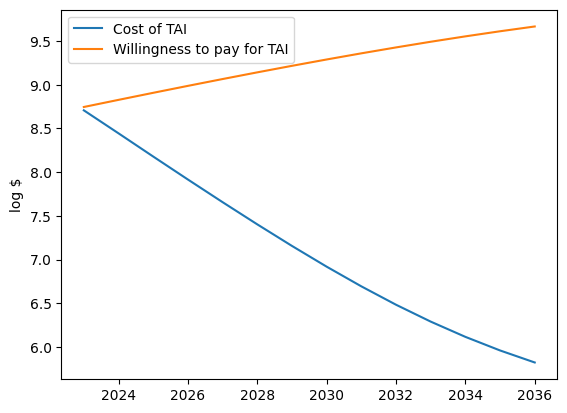

-
-
## SAMPLE RUN 2 ##
It takes 26.7 log FLOP (~501 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 21.6 log FLOP (~4 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~307 million). This doubles every 2.0 years to a max of 0.044347% of GDP. GDP grows at a rate of 1.017x per year.
---
Year: 2023 - 26.8 max log FLOP (594 septillion) available - TAI takes 26.7 log FLOP (501 septillion) - log $ 8.4 to buy TAI (251 million) vs. willingness to pay log $ 8.5 (298 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 6 years (total delay 7 years)
-- data p_non

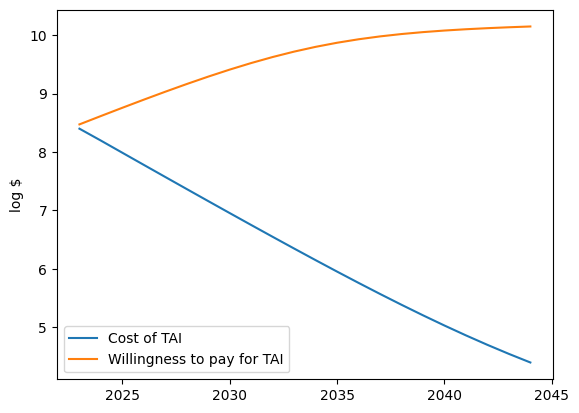

-
-
## SAMPLE RUN 3 ##
It takes 41.6 log FLOP (~398 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 3.9 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.9 years they get 2x cheaper, to a maximum of 24.5 log FLOP (~3 septillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~197 million). This doubles every 1.8 years to a max of 0.060374% of GDP. GDP grows at a rate of 1.028x per year.
---
Year: 2023 - 26.6 max log FLOP (387 septillion) available - TAI takes 41.6 log FLOP (398 million decillion) - log $ 23.3 to buy TAI (200 sextillion) vs. willingness to pay log $ 8.3 (194 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.6)
Year: 2024 - 26.9 max log FLOP (819 septillion) available - TAI takes 41.3 log FLOP (199 million decillion) - log $ 22.8 to buy TAI (69 sextillion) vs. willingness to pay log $ 8.5 (284 million) - 18.5 log FLOP per $ (3 qui

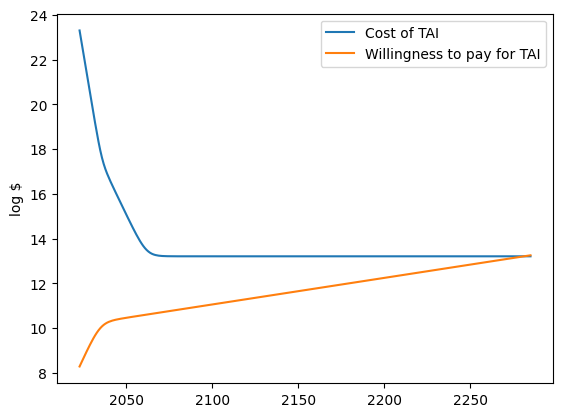

-
-
## RUN TIMELINES MODEL ##
Generating Bayes net with 5 cores...


100%|█████████████████████████████████████████████████████████████| 1000/1000 [00:33<00:00, 29.63it/s]


Shuffling data...
Writing data...
Waiting for other cores...


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.68it/s]


...Collected!
Caching in-memory...
...Cached!
Writing cache to file `caches/tai_years.sqcache`...
...Cached!
...Reducing
...Reduced!
...All done!
-
## DISTRIBUTION OF TAI ARRIVAL DATE ##
['5%: 2032',
 '10%: 2034',
 '15%: 2036',
 '20%: 2037',
 '25%: 2039',
 '35%: 2042',
 '50%: 2047',
 '60%: 2053',
 '75%: 2071',
 '80%: 2081',
 '90%: 2223',
 '95%: 2443']
(Mean: 2116)
-
-
## DISTRIBUTION OF RELATIVE TAI ARRIVAL DATE ##
['5%: 9 years from now',
 '10%: 11 years from now',
 '15%: 13 years from now',
 '20%: 14 years from now',
 '25%: 16 years from now',
 '35%: 19 years from now',
 '50%: 24 years from now',
 '60%: 30 years from now',
 '75%: 48 years from now',
 '80%: 58 years from now',
 '90%: 200 years from now',
 '95%: 420 years from now']
(Mean: 93 years from now)
-
-
## TAI ARRIVAL DATE BY BIN ##
This year: 0.0%
2024-2027: 0.0%
2028-2029: 1.2%
2030-2034: 9.9%
2035-2039: 15.9%
2040-2049: 27.4%
2050-2059: 14.5%
2060-2069: 5.4%
2070-2079: 4.4%
2080-2089: 3.5%
2090-2099: 1.8%
2100-2109: 0.9%
21

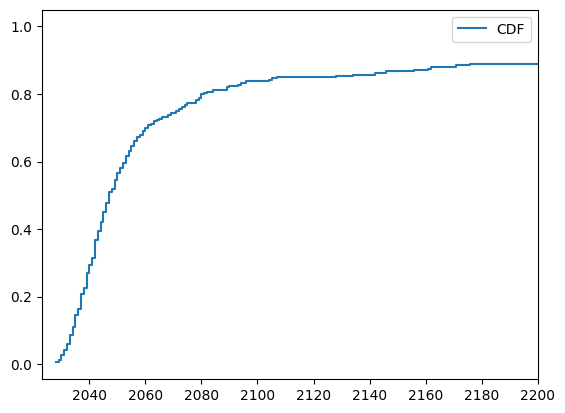

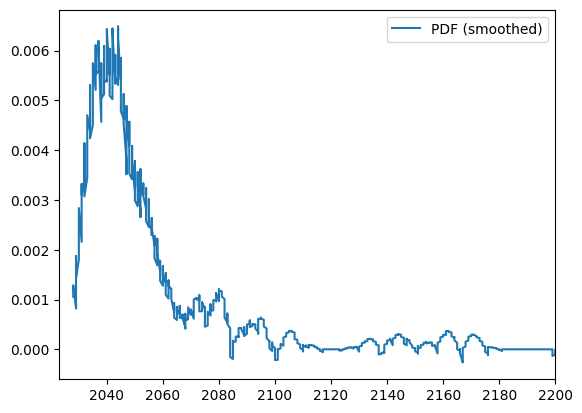

-
-
## TAI FLOP SIZE ##
{1: 23.2,
 5: 24.6,
 10: 25.3,
 20: 26.2,
 30: 26.9,
 40: 27.9,
 50: 29.0,
 60: 30.8,
 70: 32.4,
 80: 34.8,
 90: 38.5,
 95: 41.6,
 99: 47.5}
(Mean: 30.7)


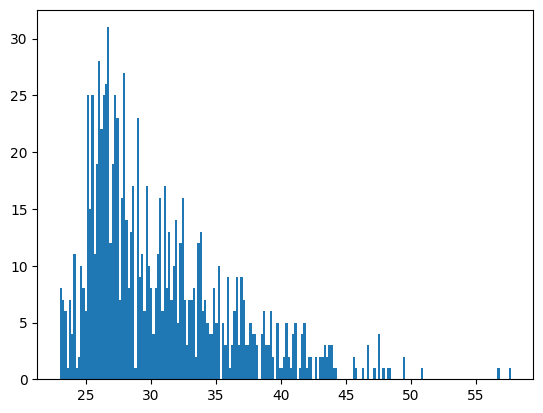

-
-
## MIN REDUCTION: 2 ##
-
## MAX REDUCTION ##
{1: 19.5,
 5: 14.7,
 10: 12.1,
 20: 10.0,
 30: 8.5,
 40: 7.5,
 50: 6.8,
 60: 5.9,
 70: 5.2,
 80: 4.5,
 90: 3.7,
 95: 2.9,
 99: 2.1}
(Mean: 7.4)


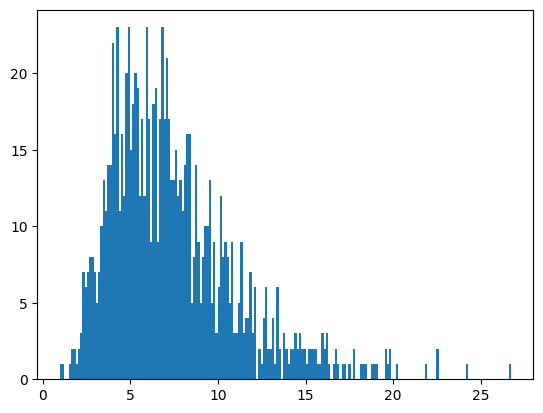

-
-
## MIN ALGO DOUBLING RATE: 1 ##
-
## MAX ALGO DOUBLING RATE: 3 ##
-
## INITIAL FLOP PER DOLLAR: 18.3 ##
-
## FLOP HALVING RATE ##
{1: 3.9,
 5: 3.4,
 10: 3.2,
 20: 3.0,
 30: 2.8,
 40: 2.7,
 50: 2.5,
 60: 2.4,
 70: 2.2,
 80: 2.0,
 90: 1.7,
 95: 1.5,
 99: 1.1}
(Mean: 2.5)


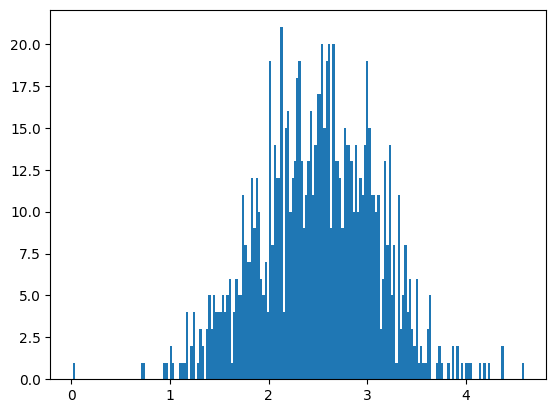

-
-
## MAX FLOP PER DOLLAR ##
{1: 20.1,
 5: 21.2,
 10: 21.7,
 20: 22.2,
 30: 22.7,
 40: 23.1,
 50: 23.4,
 60: 23.8,
 70: 24.2,
 80: 24.7,
 90: 25.4,
 95: 25.9,
 99: 27.0}
(Mean: 23.5)


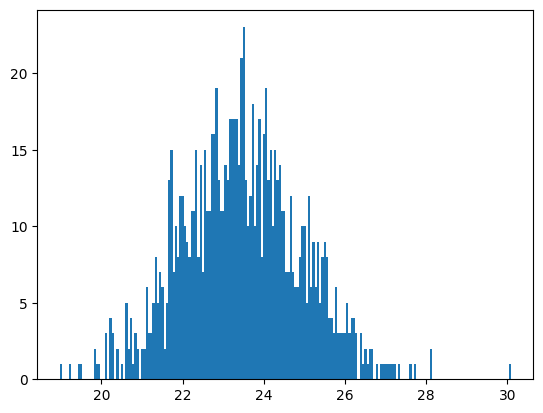

-
-
## INITIAL PAY ##
{1: 8.0,
 5: 8.2,
 10: 8.3,
 20: 8.4,
 30: 8.5,
 40: 8.6,
 50: 8.6,
 60: 8.7,
 70: 8.8,
 80: 8.9,
 90: 9.1,
 95: 9.2,
 99: 9.6}
(Mean: 8.7)


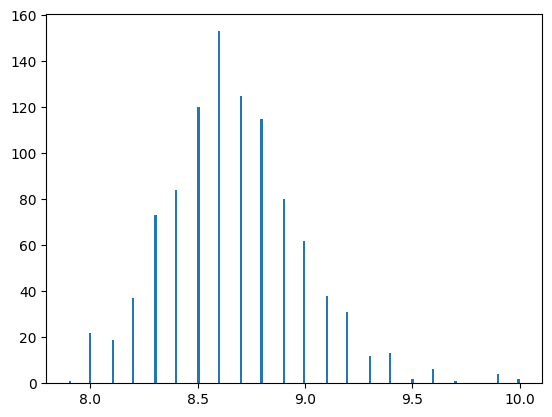

-
-
## GDP GROWTH ##
{1: 1.01,
 5: 1.01,
 10: 1.01,
 20: 1.02,
 30: 1.02,
 40: 1.02,
 50: 1.02,
 60: 1.02,
 70: 1.03,
 80: 1.03,
 90: 1.03,
 95: 1.03,
 99: 1.04}
(Mean: 1.0)


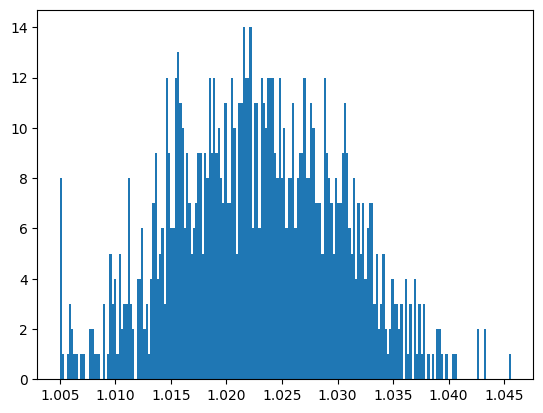

-
-
## MAX GDP FRAC ##
{1: 0.00025,
 5: 0.00025,
 10: 0.00025,
 20: 0.00025,
 30: 0.00025,
 40: 0.00032,
 50: 0.0004,
 60: 0.00052,
 70: 0.00071,
 80: 0.00099,
 90: 0.00181,
 95: 0.00346,
 99: 0.01}
(Mean: 0.0)


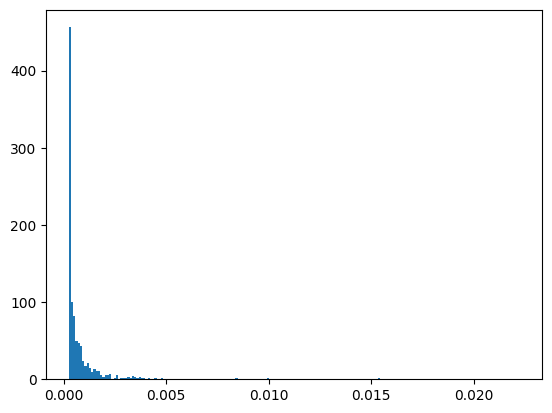

-
-
## SPEND DOUBLING TIME ##
{1: 5.2,
 5: 4.5,
 10: 4.2,
 20: 3.7,
 30: 3.4,
 40: 3.0,
 50: 2.7,
 60: 2.5,
 70: 2.2,
 80: 1.9,
 90: 1.5,
 95: 1.1,
 99: 0.9}
(Mean: 2.8)


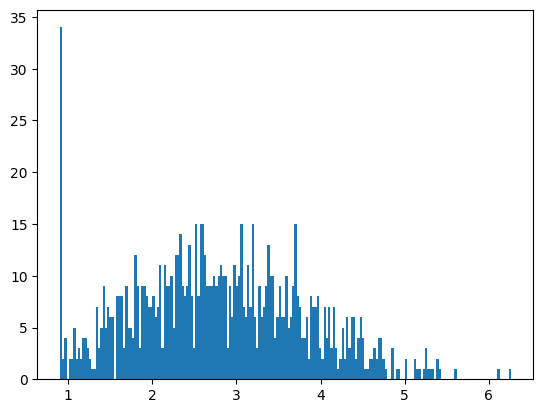

-
-
-
-
## GDP Over Time ##


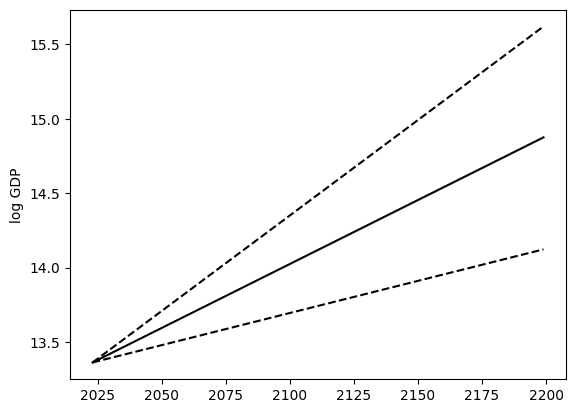

Year: 2023 - GDP log 2022$USD 13.4 (~23 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~23 trillion)
Year: 2024 - GDP log 2022$USD 13.4 (~23 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~24 trillion)
Year: 2025 - GDP log 2022$USD 13.4 (~24 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~24 trillion)
Year: 2026 - GDP log 2022$USD 13.4 (~24 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~25 trillion)
Year: 2027 - GDP log 2022$USD 13.4 (~25 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~26 trillion)
Year: 2028 - GDP log 2022$USD 13.4 (~25 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~27 trillion)
Year: 2029 - GDP log 2022$USD 13.4 (~26 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~27 trillion)
Year: 2030 - GDP log 2022$USD 13.4 (~26 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~28 trillion)
Year: 2031 - GDP log 2022$USD 13.4 (~27 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~29 trillion)
Year: 2032 - GDP log 2022$USD 13.4 (~27 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~30 trillion)
Year: 2033

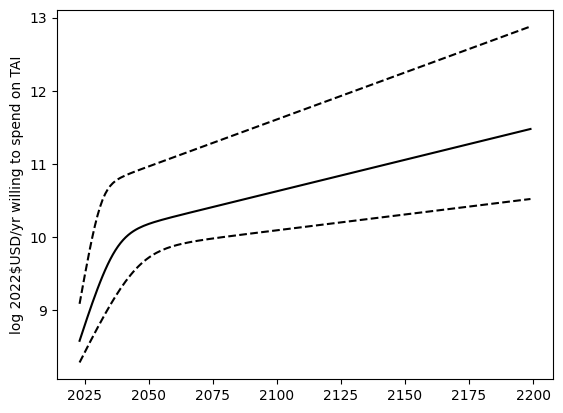

Year: 2023 - willingness log 2022$USD per year 8.6 (~382 million) 90% CI 8.3 (~193 million) - 9.1 (~1 billion)
Year: 2024 - willingness log 2022$USD per year 8.7 (~488 million) 90% CI 8.4 (~226 million) - 9.3 (~2 billion)
Year: 2025 - willingness log 2022$USD per year 8.8 (~622 million) 90% CI 8.4 (~265 million) - 9.5 (~3 billion)
Year: 2026 - willingness log 2022$USD per year 8.9 (~790 million) 90% CI 8.5 (~310 million) - 9.7 (~5 billion)
Year: 2027 - willingness log 2022$USD per year 9.0 (~1 billion) 90% CI 8.6 (~363 million) - 9.8 (~7 billion)
Year: 2028 - willingness log 2022$USD per year 9.1 (~1 billion) 90% CI 8.6 (~423 million) - 10.0 (~10 billion)
Year: 2029 - willingness log 2022$USD per year 9.2 (~2 billion) 90% CI 8.7 (~494 million) - 10.2 (~14 billion)
Year: 2030 - willingness log 2022$USD per year 9.3 (~2 billion) 90% CI 8.8 (~574 million) - 10.3 (~20 billion)
Year: 2031 - willingness log 2022$USD per year 9.4 (~2 billion) 90% CI 8.8 (~667 million) - 10.4 (~26 billion)
Yea

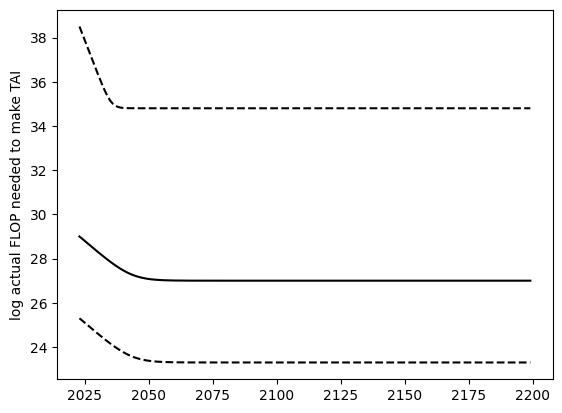

Year: 2023 - log FLOP needed for TAI 29.0 (~100 octillion) 90% CI 25.3 (~20 septillion) - 38.5 (~316 thousand decillion)
Year: 2024 - log FLOP needed for TAI 28.9 (~80 octillion) 90% CI 25.2 (~16 septillion) - 38.2 (~158 thousand decillion)
Year: 2025 - log FLOP needed for TAI 28.8 (~64 octillion) 90% CI 25.1 (~13 septillion) - 37.9 (~79 thousand decillion)
Year: 2026 - log FLOP needed for TAI 28.7 (~51 octillion) 90% CI 25.0 (~10 septillion) - 37.6 (~40 thousand decillion)
Year: 2027 - log FLOP needed for TAI 28.6 (~41 octillion) 90% CI 24.9 (~8 septillion) - 37.3 (~20 thousand decillion)
Year: 2028 - log FLOP needed for TAI 28.5 (~32 octillion) 90% CI 24.8 (~6 septillion) - 37.0 (~10 thousand decillion)
Year: 2029 - log FLOP needed for TAI 28.4 (~26 octillion) 90% CI 24.7 (~5 septillion) - 36.7 (~5 thousand decillion)
Year: 2030 - log FLOP needed for TAI 28.3 (~21 octillion) 90% CI 24.6 (~4 septillion) - 36.4 (~3 thousand decillion)
Year: 2031 - log FLOP needed for TAI 28.2 (~17 octi

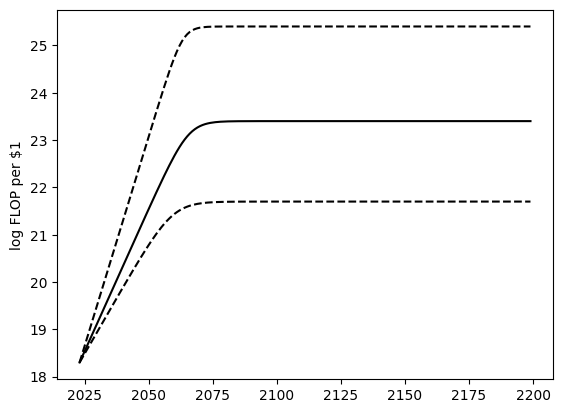

Year: 2023 - log FLOP per 2022$1USD 18.3 (~2 quintillion) 90% CI 18.3 (~2 quintillion) - 18.3 (~2 quintillion)
Year: 2024 - log FLOP per 2022$1USD 18.4 (~3 quintillion) 90% CI 18.4 (~2 quintillion) - 18.5 (~3 quintillion)
Year: 2025 - log FLOP per 2022$1USD 18.5 (~3 quintillion) 90% CI 18.5 (~3 quintillion) - 18.7 (~5 quintillion)
Year: 2026 - log FLOP per 2022$1USD 18.7 (~5 quintillion) 90% CI 18.6 (~4 quintillion) - 18.8 (~7 quintillion)
Year: 2027 - log FLOP per 2022$1USD 18.8 (~6 quintillion) 90% CI 18.7 (~5 quintillion) - 19.0 (~10 quintillion)
Year: 2028 - log FLOP per 2022$1USD 18.9 (~8 quintillion) 90% CI 18.8 (~6 quintillion) - 19.2 (~15 quintillion)
Year: 2029 - log FLOP per 2022$1USD 19.0 (~11 quintillion) 90% CI 18.9 (~7 quintillion) - 19.4 (~23 quintillion)
Year: 2030 - log FLOP per 2022$1USD 19.1 (~14 quintillion) 90% CI 19.0 (~9 quintillion) - 19.5 (~35 quintillion)
Year: 2031 - log FLOP per 2022$1USD 19.3 (~18 quintillion) 90% CI 19.1 (~11 quintillion) - 19.7 (~52 quint

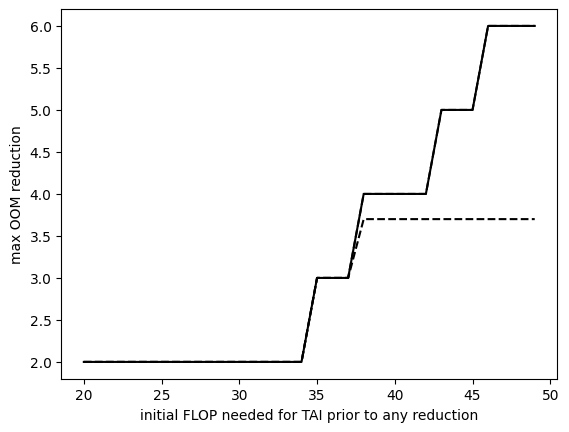

TAI log FLOP 20 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 21 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 22 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 23 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 24 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 25 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 26 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 27 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 28 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 29 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 30 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 31 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 32 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 33 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 34 -> 2.0 OOM reductions possible (

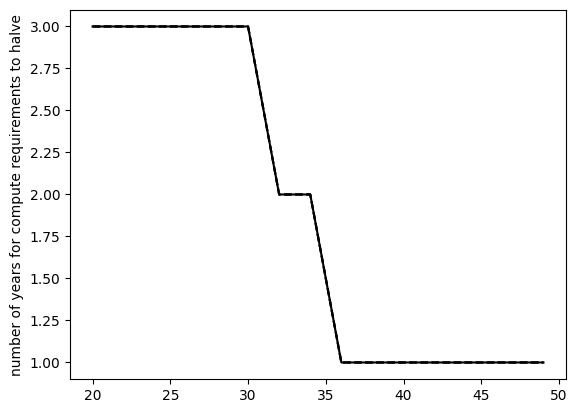

TAI log FLOP 20 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 21 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 22 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 23 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 24 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 25 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 26 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 27 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 28 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 29 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 30 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 31 -> algo doubling rate 2.5yrs (90% CI: 2.5 to 2.5)
TAI log FLOP 32 -> algo doubling rate 2.0yrs (90% CI: 2.0 to 2.0)
TAI log FLOP 33 -> algo doubling rate 2.0yrs (90% CI: 2.0 to 2.0)
TAI log FLOP 34 -> algo doubling rate 2.0yrs (90% CI: 2.0 to 2.0)
TAI log FL

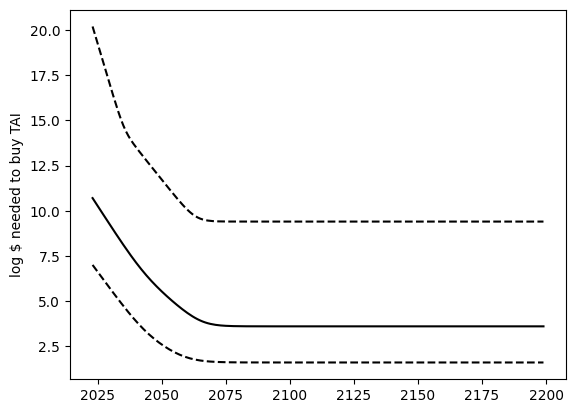

Year: 2023 - 10.7 log 2022$USD to buy TAI (~50 billion) 90% CI 7.0 (~10 million) - 20.2 (~158 quintillion)
Year: 2024 - 10.5 log 2022$USD to buy TAI (~31 billion) 90% CI 6.8 (~6 million) - 19.7 (~53 quintillion)
Year: 2025 - 10.3 log 2022$USD to buy TAI (~18 billion) 90% CI 6.6 (~4 million) - 19.2 (~18 quintillion)
Year: 2026 - 10.0 log 2022$USD to buy TAI (~11 billion) 90% CI 6.4 (~3 million) - 18.8 (~6 quintillion)
Year: 2027 - 9.8 log 2022$USD to buy TAI (~7 billion) 90% CI 6.2 (~2 million) - 18.3 (~2 quintillion)
Year: 2028 - 9.6 log 2022$USD to buy TAI (~4 billion) 90% CI 6.0 (~1 million) - 17.8 (~649 quadrillion)
Year: 2029 - 9.4 log 2022$USD to buy TAI (~2 billion) 90% CI 5.9 (~710 thousand) - 17.3 (~217 quadrillion)
Year: 2030 - 9.2 log 2022$USD to buy TAI (~1 billion) 90% CI 5.7 (~458 thousand) - 16.9 (~73 quadrillion)
Year: 2031 - 9.0 log 2022$USD to buy TAI (~914 million) 90% CI 5.5 (~297 thousand) - 16.4 (~25 quadrillion)
Year: 2032 - 8.7 log 2022$USD to buy TAI (~558 milli

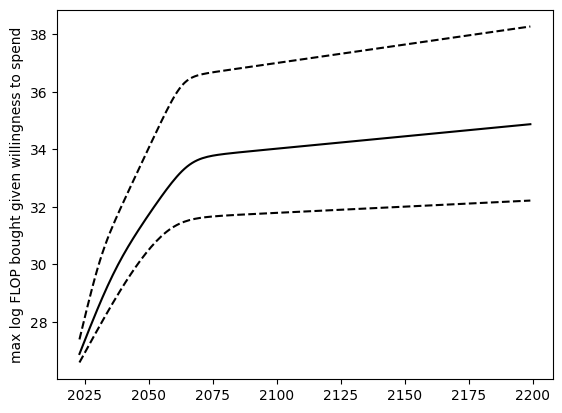

Year: 2023 - max log FLOP 26.9 (~761 septillion) 90% CI 26.6 (~385 septillion) - 27.4 (~2 octillion)
Year: 2024 - max log FLOP 27.1 (~1 octillion) 90% CI 26.7 (~560 septillion) - 27.8 (~6 octillion)
Year: 2025 - max log FLOP 27.3 (~2 octillion) 90% CI 26.9 (~815 septillion) - 28.1 (~13 octillion)
Year: 2026 - max log FLOP 27.6 (~4 octillion) 90% CI 27.1 (~1 octillion) - 28.5 (~31 octillion)
Year: 2027 - max log FLOP 27.8 (~6 octillion) 90% CI 27.2 (~2 octillion) - 28.8 (~70 octillion)
Year: 2028 - max log FLOP 28.0 (~10 octillion) 90% CI 27.4 (~2 octillion) - 29.2 (~154 octillion)
Year: 2029 - max log FLOP 28.2 (~17 octillion) 90% CI 27.6 (~4 octillion) - 29.5 (~330 octillion)
Year: 2030 - max log FLOP 28.4 (~27 octillion) 90% CI 27.7 (~5 octillion) - 29.8 (~682 octillion)
Year: 2031 - max log FLOP 28.6 (~44 octillion) 90% CI 27.9 (~8 octillion) - 30.1 (~1 nonillion)
Year: 2032 - max log FLOP 28.9 (~71 octillion) 90% CI 28.0 (~11 octillion) - 30.4 (~3 nonillion)
Year: 2033 - max log FL

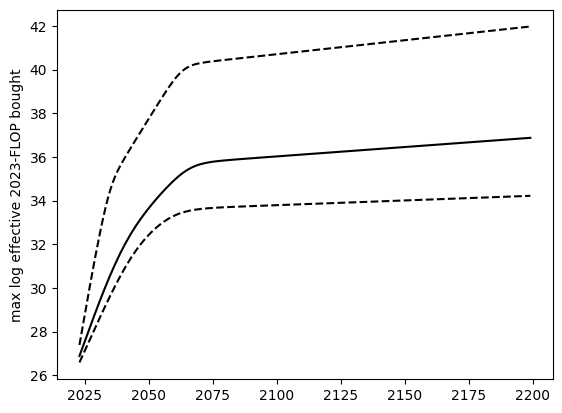

Year: 2023 - max log effective 2023-FLOP 26.9 (~761 septillion) 90% CI 26.6 (~385 septillion) - 27.4 (~2 octillion)
Year: 2024 - max log effective 2023-FLOP 27.2 (~2 octillion) 90% CI 26.8 (~697 septillion) - 28.1 (~11 octillion)
Year: 2025 - max log effective 2023-FLOP 27.5 (~3 octillion) 90% CI 27.1 (~1 octillion) - 28.7 (~53 octillion)
Year: 2026 - max log effective 2023-FLOP 27.9 (~7 octillion) 90% CI 27.4 (~2 octillion) - 29.4 (~246 octillion)
Year: 2027 - max log effective 2023-FLOP 28.2 (~15 octillion) 90% CI 27.6 (~4 octillion) - 30.0 (~1 nonillion)
Year: 2028 - max log effective 2023-FLOP 28.5 (~31 octillion) 90% CI 27.9 (~8 octillion) - 30.7 (~5 nonillion)
Year: 2029 - max log effective 2023-FLOP 28.8 (~64 octillion) 90% CI 28.1 (~14 octillion) - 31.3 (~21 nonillion)
Year: 2030 - max log effective 2023-FLOP 29.1 (~130 octillion) 90% CI 28.4 (~25 octillion) - 31.9 (~85 nonillion)
Year: 2031 - max log effective 2023-FLOP 29.4 (~264 octillion) 90% CI 28.7 (~45 octillion) - 32.5 

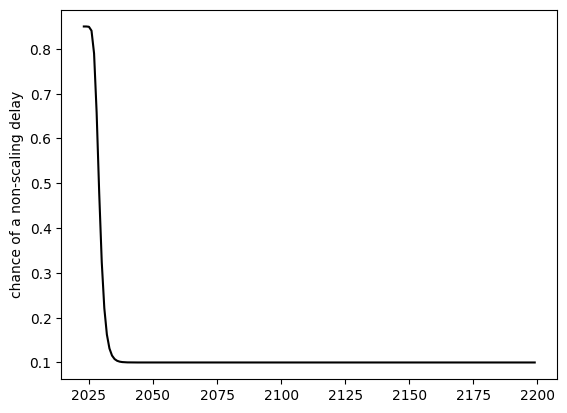

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 85%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 85%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 85%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 84%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 79%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 66%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 48%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 32%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 22%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 16%
Year: 2033

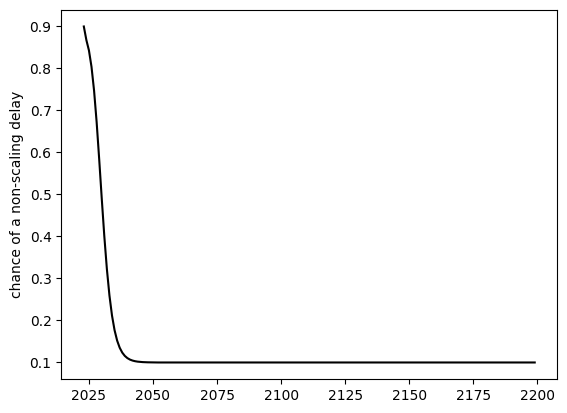

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 90%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 87%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 84%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 80%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 75%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 67%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 58%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 49%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 32%
Year: 2033

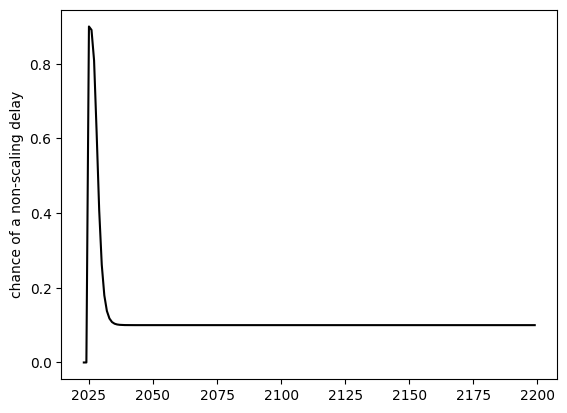

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 0%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 0%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 90%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 89%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 81%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 62%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 41%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 26%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 18%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 14%
Year: 2033 -

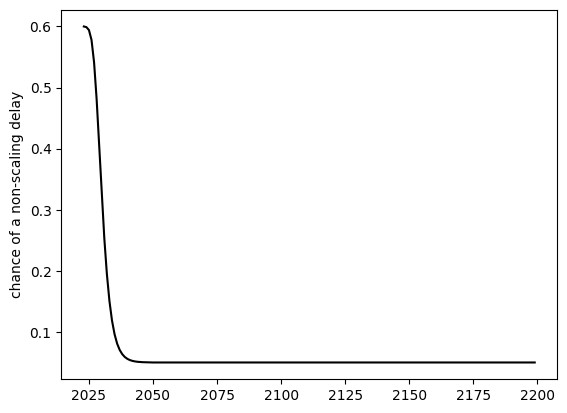

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 59%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 58%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 54%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 48%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 32%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 25%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 19%
Year: 2033

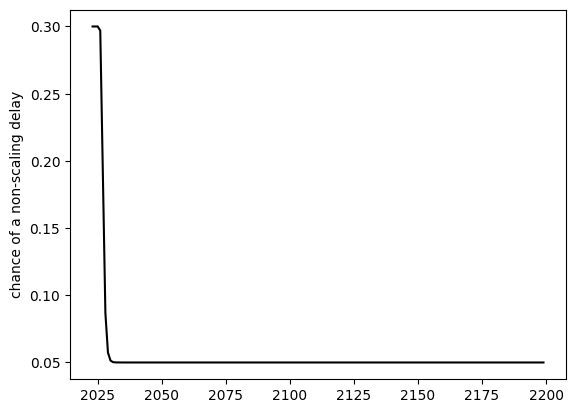

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 19%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 9%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 6%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2033 - ch

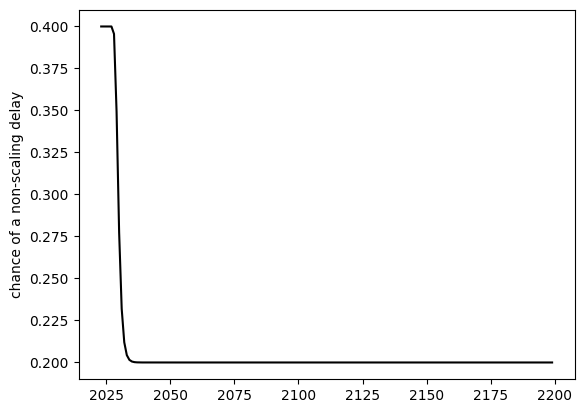

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 35%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 28%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 23%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 21%
Year: 2033

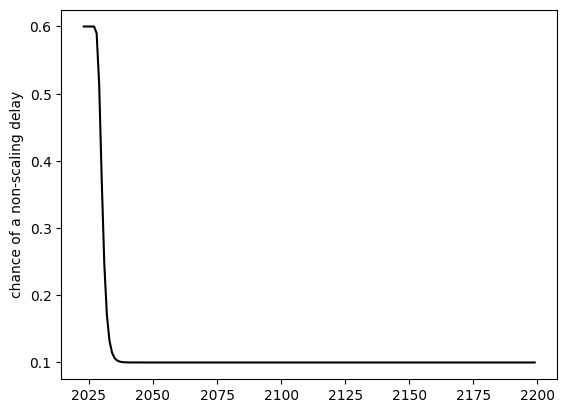

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 59%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 51%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 37%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 25%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 17%
Year: 2033

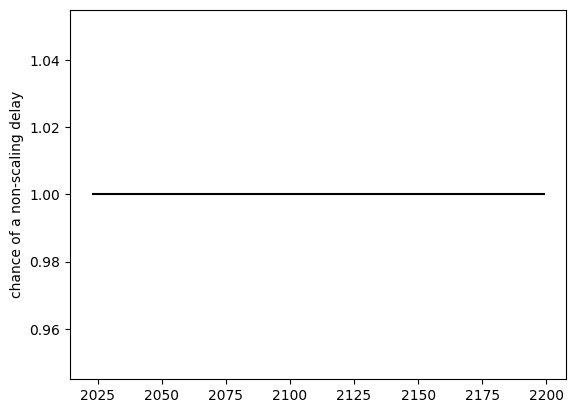

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%


/Users/peterhurford/.virtualenvs/dev/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/peterhurford/.virtualenvs/dev/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: cannot convert float NaN to integer

In [9]:
variables['RUNS'] = RUNS
variables['CURRENT_YEAR'] = CURRENT_YEAR
variables['MAX_YEAR'] = MAX_YEAR

run_timelines_model(variables,
                    cores=5,
                    runs=variables['RUNS'],
                    #dump_cache_file='caches/tai_years_metaculus_parity')
                    dump_cache_file='caches/tai_years')


-
-
## SAMPLE RUN 4 ##
It takes 30.4 log FLOP (~3 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 25.9 log FLOP (~83 septillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~765 million). This doubles every 2.8 years to a max of 0.08989% of GDP. GDP grows at a rate of 1.02x per year.
---
Year: 2023 - 27.2 max log FLOP (1 octillion) available - TAI takes 30.4 log FLOP (3 nonillion) - log $ 12.1 to buy TAI (1 trillion) vs. willingness to pay log $ 8.9 (738 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.2)
Year: 2024 - 27.4 max log FLOP (2 octillion) available - TAI takes 30.3 log FLOP (2 nonillion) - log $ 11.9 to buy TAI (731 billion) vs. willingness to pay log $ 9.0 (938 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.3)
Ye

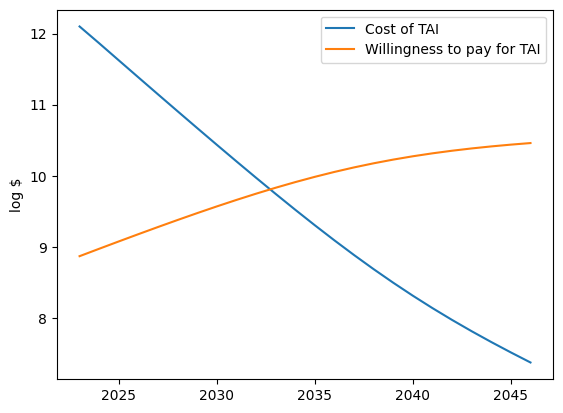

-
-
## SAMPLE RUN 5 ##
It takes 25.6 log FLOP (~40 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.0 years they get 2x cheaper, to a maximum of 21.0 log FLOP (~973 quintillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~488 million). This doubles every 3.3 years to a max of 0.080478% of GDP. GDP grows at a rate of 1.029x per year.
---
Year: 2023 - 27.0 max log FLOP (947 septillion) available - TAI takes 25.6 log FLOP (40 septillion) - log $ 7.3 to buy TAI (20 million) vs. willingness to pay log $ 8.7 (475 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.0)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 4 years)
-- data p_non

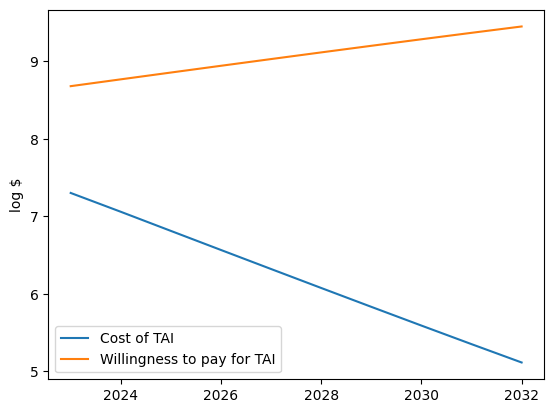

-
-
## SAMPLE RUN 6 ##
It takes 31.3 log FLOP (~20 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 22.8 log FLOP (~67 sextillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~750 million). This doubles every 5.8 years to a max of 0.057874% of GDP. GDP grows at a rate of 1.031x per year.
---
Year: 2023 - 27.2 max log FLOP (1 octillion) available - TAI takes 31.3 log FLOP (20 nonillion) - log $ 13.0 to buy TAI (10 trillion) vs. willingness to pay log $ 8.9 (710 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.2)
Year: 2024 - 27.3 max log FLOP (2 octillion) available - TAI takes 31.2 log FLOP (15 nonillion) - log $ 12.8 to buy TAI (6 trillion) vs. willingness to pay log $ 8.9 (796 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.

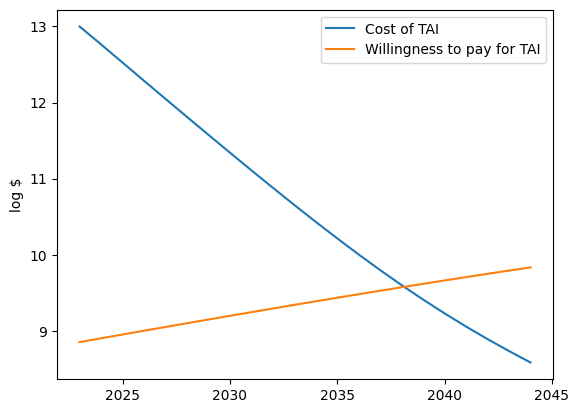

-
-
## SAMPLE RUN 7 ##
It takes 25.1 log FLOP (~13 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.0 years they get 2x cheaper, to a maximum of 21.2 log FLOP (~2 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~382 million). This doubles every 3.3 years to a max of 0.041818% of GDP. GDP grows at a rate of 1.028x per year.
---
Year: 2023 - 26.9 max log FLOP (733 septillion) available - TAI takes 25.1 log FLOP (13 septillion) - log $ 6.8 to buy TAI (6 million) vs. willingness to pay log $ 8.6 (368 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.9)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 1 years (total delay 1 years)
-- data p_nonscaling_issue p=0.0 -> Nonscaling issue did not 

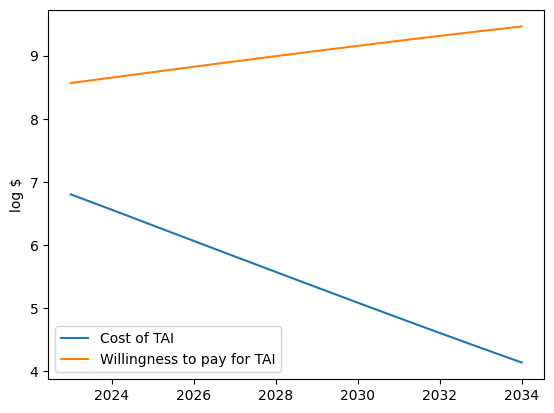

-
-
## SAMPLE RUN 8 ##
It takes 28.6 log FLOP (~40 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 23.2 log FLOP (~171 sextillion) per 2022$USD.
We are initially willing to pay 9.0 log 2022$USD (~1 billion). This doubles every 3.7 years to a max of 0.025% of GDP. GDP grows at a rate of 1.01x per year.
---
Year: 2023 - 27.2 max log FLOP (2 octillion) available - TAI takes 28.6 log FLOP (40 octillion) - log $ 10.3 to buy TAI (20 billion) vs. willingness to pay log $ 8.9 (876 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.2)
Year: 2024 - 27.4 max log FLOP (3 octillion) available - TAI takes 28.5 log FLOP (32 octillion) - log $ 10.1 to buy TAI (12 billion) vs. willingness to pay log $ 9.0 (1 billion) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.3)
Year:

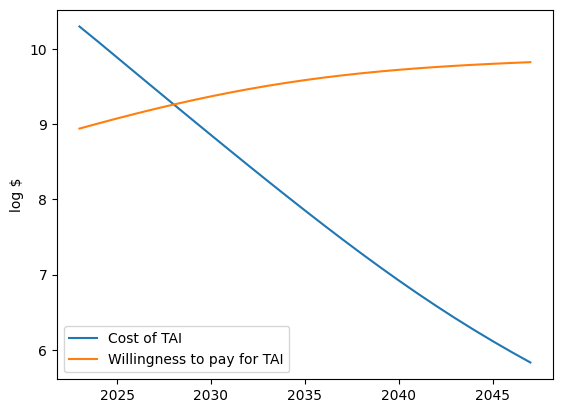

-
-
## SAMPLE RUN 9 ##
It takes 26.1 log FLOP (~126 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 22.0 log FLOP (~10 sextillion) per 2022$USD.
We are initially willing to pay 9.2 log 2022$USD (~2 billion). This doubles every 1.3 years to a max of 0.030151% of GDP. GDP grows at a rate of 1.018x per year.
---
Year: 2023 - 27.4 max log FLOP (3 octillion) available - TAI takes 26.1 log FLOP (126 septillion) - log $ 7.8 to buy TAI (63 million) vs. willingness to pay log $ 9.1 (1 billion) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.4)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 10 years (total delay 12 years)
-- data p_nonscali

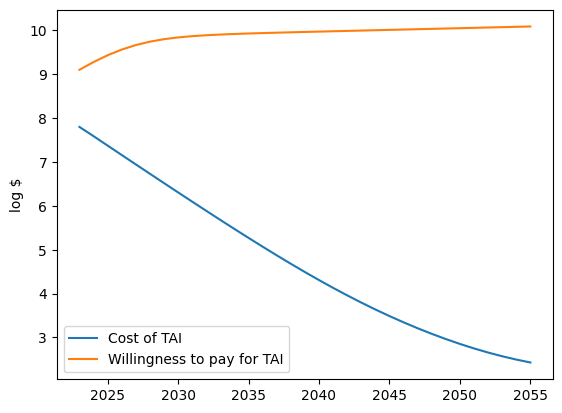

-
-
## SAMPLE RUN 10 ##
It takes 31.6 log FLOP (~40 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.6 years they get 2x cheaper, to a maximum of 21.5 log FLOP (~3 sextillion) per 2022$USD.
We are initially willing to pay 9.1 log 2022$USD (~1 billion). This doubles every 2.6 years to a max of 0.031185% of GDP. GDP grows at a rate of 1.03x per year.
---
Year: 2023 - 27.3 max log FLOP (2 octillion) available - TAI takes 31.6 log FLOP (40 nonillion) - log $ 13.3 to buy TAI (20 trillion) vs. willingness to pay log $ 9.0 (1 billion) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.3)
Year: 2024 - 27.6 max log FLOP (4 octillion) available - TAI takes 31.5 log FLOP (31 nonillion) - log $ 13.0 to buy TAI (10 trillion) vs. willingness to pay log $ 9.1 (1 billion) - 18.5 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.4)
Yea

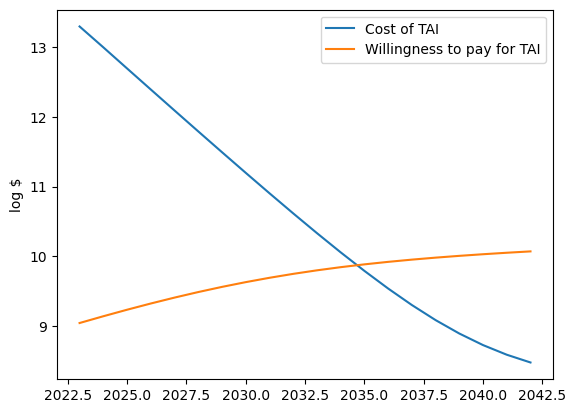

-
-
## SAMPLE RUN 11 ##
It takes 33.9 log FLOP (~8 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 22.3 log FLOP (~19 sextillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~155 million). This doubles every 3.3 years to a max of 0.035125% of GDP. GDP grows at a rate of 1.034x per year.
---
Year: 2023 - 26.5 max log FLOP (304 septillion) available - TAI takes 33.9 log FLOP (8 decillion) - log $ 15.6 to buy TAI (4 quadrillion) vs. willingness to pay log $ 8.2 (153 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.5)
Year: 2024 - 26.7 max log FLOP (485 septillion) available - TAI takes 33.8 log FLOP (6 decillion) - log $ 15.3 to buy TAI (2 quadrillion) vs. willingness to pay log $ 8.3 (187 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-log

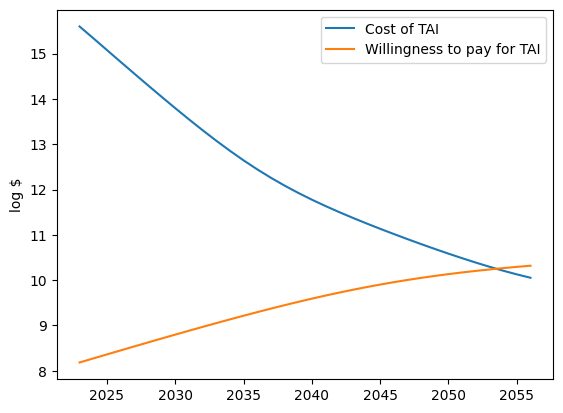

-
-
## SAMPLE RUN 12 ##
It takes 45.1 log FLOP (~1 trillion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 5 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.6 years they get 2x cheaper, to a maximum of 23.3 log FLOP (~194 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~461 million). This doubles every 2.2 years to a max of 0.025% of GDP. GDP grows at a rate of 1.034x per year.
---
Year: 2023 - 26.9 max log FLOP (852 septillion) available - TAI takes 45.1 log FLOP (1 trillion decillion) - log $ 26.8 to buy TAI (631 septillion) vs. willingness to pay log $ 8.6 (427 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.9)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 44.8 log FLOP (629 billion decillion) - log $ 26.4 to buy TAI (261 septillion) vs. willingness to pay log $ 8.8 (570 million) - 18.4 log FLOP per $ (2 quintilli

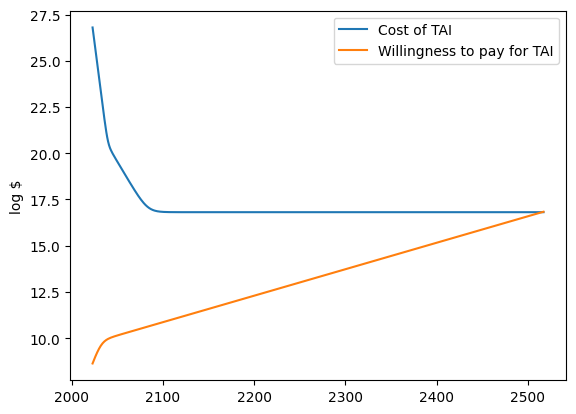

-
-
## SAMPLE RUN 13 ##
It takes 43.3 log FLOP (~20 billion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 5 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.1 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~7 sextillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~156 million). This doubles every 2.1 years to a max of 0.038496% of GDP. GDP grows at a rate of 1.014x per year.
---
Year: 2023 - 26.5 max log FLOP (305 septillion) available - TAI takes 43.3 log FLOP (20 billion decillion) - log $ 25.0 to buy TAI (10 septillion) vs. willingness to pay log $ 8.2 (153 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.5)
Year: 2024 - 26.7 max log FLOP (528 septillion) available - TAI takes 43.0 log FLOP (10 billion decillion) - log $ 24.6 to buy TAI (4 septillion) vs. willingness to pay log $ 8.3 (212 million) - 18.4 log FLOP per $ (2 quintilli

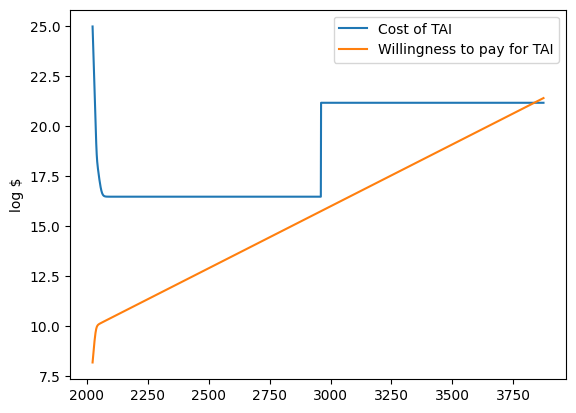

-
-
## SAMPLE RUN 14 ##
It takes 25.5 log FLOP (~32 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.0 years they get 2x cheaper, to a maximum of 22.2 log FLOP (~17 sextillion) per 2022$USD.
We are initially willing to pay 9.0 log 2022$USD (~1 billion). This doubles every 5.6 years to a max of 0.025% of GDP. GDP grows at a rate of 1.02x per year.
---
Year: 2023 - 27.2 max log FLOP (2 octillion) available - TAI takes 25.5 log FLOP (32 septillion) - log $ 7.2 to buy TAI (16 million) vs. willingness to pay log $ 8.9 (876 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.2)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 5 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 6 years (total delay 7 years)
-- data p_nonscaling_is

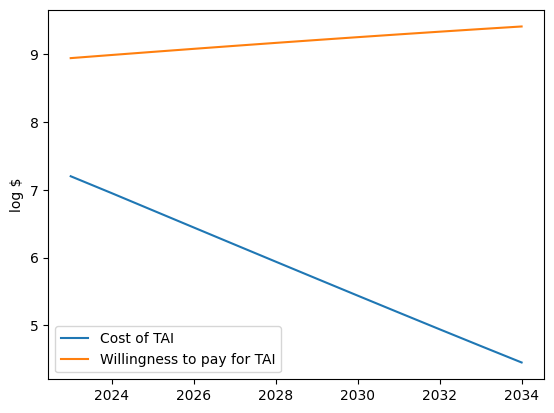

-
-
## SAMPLE RUN 15 ##
It takes 29.0 log FLOP (~100 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.0 years they get 2x cheaper, to a maximum of 23.3 log FLOP (~210 sextillion) per 2022$USD.
We are initially willing to pay 9.0 log 2022$USD (~1 billion). This doubles every 1.7 years to a max of 0.025% of GDP. GDP grows at a rate of 1.007x per year.
---
Year: 2023 - 27.2 max log FLOP (2 octillion) available - TAI takes 29.0 log FLOP (100 octillion) - log $ 10.7 to buy TAI (50 billion) vs. willingness to pay log $ 8.9 (876 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.2)
Year: 2024 - 27.5 max log FLOP (3 octillion) available - TAI takes 28.9 log FLOP (80 octillion) - log $ 10.5 to buy TAI (32 billion) vs. willingness to pay log $ 9.1 (1 billion) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.4)
Y

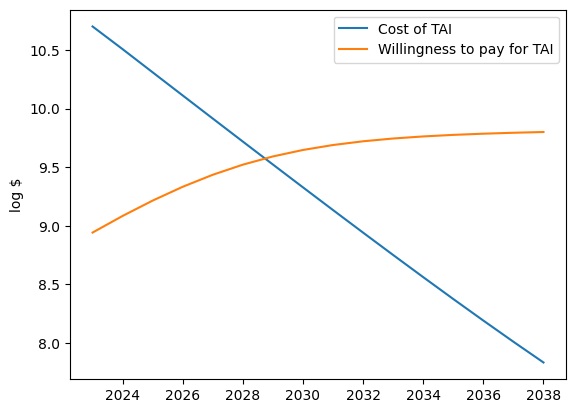

-
-
## SAMPLE RUN 16 ##
It takes 25.4 log FLOP (~25 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.1 years they get 2x cheaper, to a maximum of 23.6 log FLOP (~362 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~461 million). This doubles every 2.7 years to a max of 0.025% of GDP. GDP grows at a rate of 1.018x per year.
---
Year: 2023 - 26.9 max log FLOP (852 septillion) available - TAI takes 25.4 log FLOP (25 septillion) - log $ 7.1 to buy TAI (13 million) vs. willingness to pay log $ 8.6 (427 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.9)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling delay occured
-- -- this delay is 8 years (total delay 8 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 8 years)
-- data p_nonsca

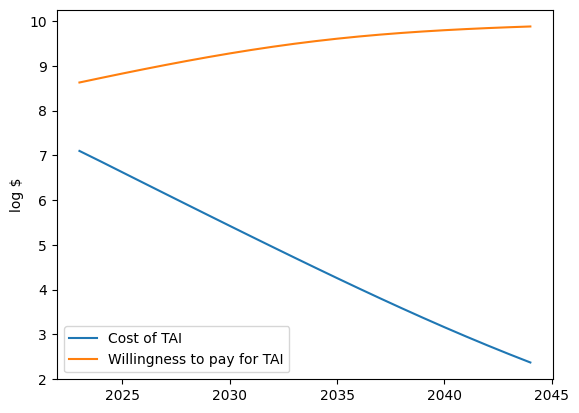

-
-
## SAMPLE RUN 17 ##
It takes 28.8 log FLOP (~63 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 21.9 log FLOP (~8 sextillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~788 million). This doubles every 3.4 years to a max of 0.412788% of GDP. GDP grows at a rate of 1.016x per year.
---
Year: 2023 - 27.2 max log FLOP (2 octillion) available - TAI takes 28.8 log FLOP (63 octillion) - log $ 10.5 to buy TAI (32 billion) vs. willingness to pay log $ 8.9 (781 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.2)
Year: 2024 - 27.4 max log FLOP (3 octillion) available - TAI takes 28.7 log FLOP (51 octillion) - log $ 10.3 to buy TAI (19 billion) vs. willingness to pay log $ 9.0 (959 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.3

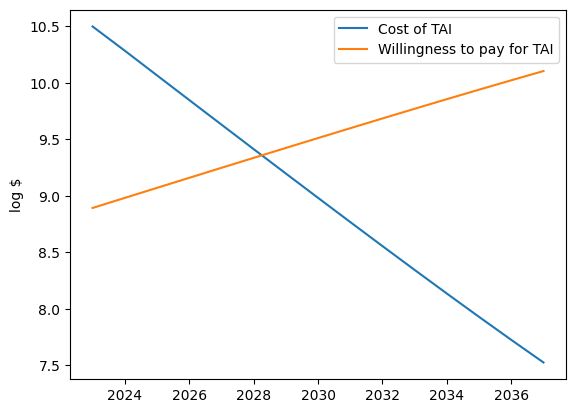

-
-
## SAMPLE RUN 18 ##
It takes 27.6 log FLOP (~4 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 22.8 log FLOP (~65 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~463 million). This doubles every 3.8 years to a max of 0.026744% of GDP. GDP grows at a rate of 1.026x per year.
---
Year: 2023 - 26.9 max log FLOP (860 septillion) available - TAI takes 27.6 log FLOP (4 octillion) - log $ 9.3 to buy TAI (2 billion) vs. willingness to pay log $ 8.6 (431 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.9)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 27.5 log FLOP (3 octillion) - log $ 9.1 to buy TAI (1 billion) vs. willingness to pay log $ 8.7 (512 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.0)
Yea

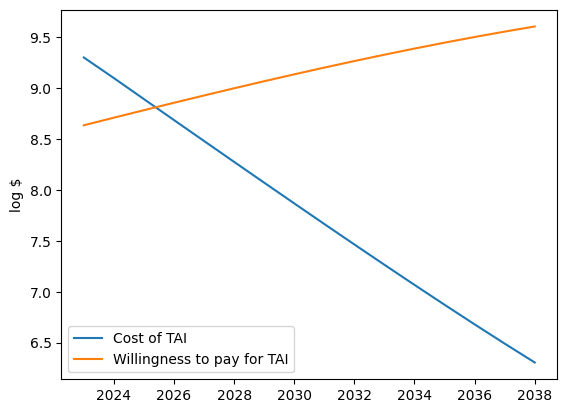

-
-
## SAMPLE RUN 19 ##
It takes 25.6 log FLOP (~40 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~7 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~310 million). This doubles every 3.1 years to a max of 0.065246% of GDP. GDP grows at a rate of 1.021x per year.
---
Year: 2023 - 26.8 max log FLOP (605 septillion) available - TAI takes 25.6 log FLOP (40 septillion) - log $ 7.3 to buy TAI (20 million) vs. willingness to pay log $ 8.5 (303 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling delay occured
-- -- this delay is 7 years (total delay 7 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 8 years)
-- data p_nonsc

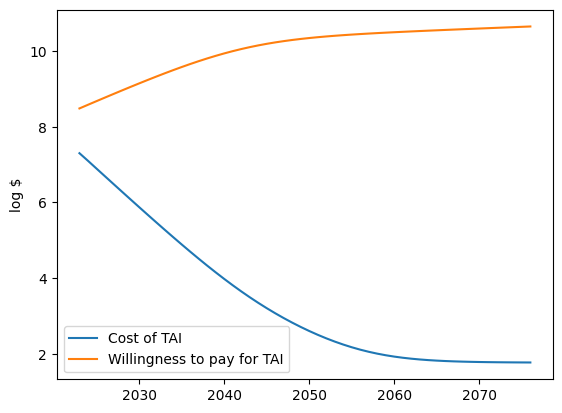

-
-
## SAMPLE RUN 20 ##
It takes 25.9 log FLOP (~79 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.3 years they get 2x cheaper, to a maximum of 21.2 log FLOP (~2 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~310 million). This doubles every 2.5 years to a max of 0.06814% of GDP. GDP grows at a rate of 1.009x per year.
---
Year: 2023 - 26.8 max log FLOP (606 septillion) available - TAI takes 25.9 log FLOP (79 septillion) - log $ 7.6 to buy TAI (40 million) vs. willingness to pay log $ 8.5 (304 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling delay occured
-- -- this delay is 7 years (total delay 7 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 7 years)
-- data p_nonsca

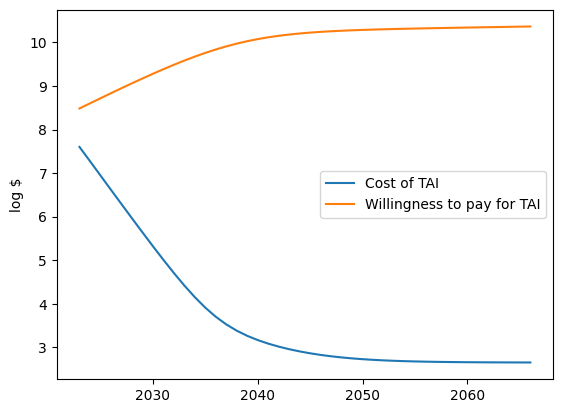

-
-
## SAMPLE RUN 21 ##
It takes 25.6 log FLOP (~40 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 0.8 years they get 2x cheaper, to a maximum of 20.8 log FLOP (~667 quintillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~569 million). This doubles every 1.4 years to a max of 0.025% of GDP. GDP grows at a rate of 1.021x per year.
---
Year: 2023 - 27.0 max log FLOP (1 octillion) available - TAI takes 25.6 log FLOP (40 septillion) - log $ 7.3 to buy TAI (20 million) vs. willingness to pay log $ 8.7 (517 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.0)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 11 years (total delay 11 years)
-- data p_nonscaling_issue p=0.0 -> Nonscaling issue did not

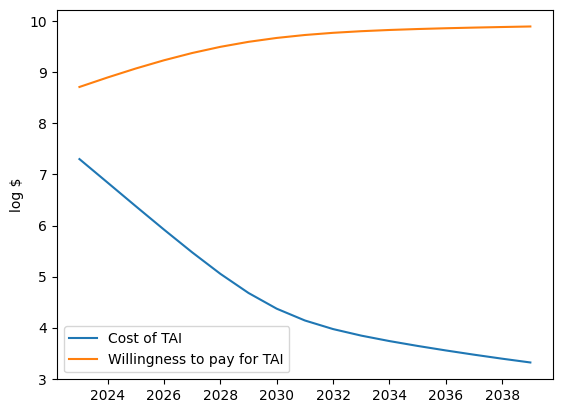

-
-
## SAMPLE RUN 22 ##
It takes 31.5 log FLOP (~32 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 24.2 log FLOP (~2 septillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~852 million). This doubles every 3.6 years to a max of 0.025% of GDP. GDP grows at a rate of 1.019x per year.
---
Year: 2023 - 27.2 max log FLOP (1 octillion) available - TAI takes 31.5 log FLOP (32 nonillion) - log $ 13.2 to buy TAI (16 trillion) vs. willingness to pay log $ 8.9 (742 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.2)
Year: 2024 - 27.4 max log FLOP (2 octillion) available - TAI takes 31.4 log FLOP (24 nonillion) - log $ 13.0 to buy TAI (9 trillion) vs. willingness to pay log $ 8.9 (879 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.2)


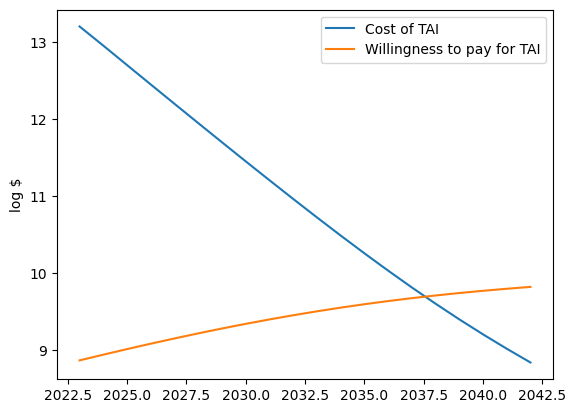

-
-
## SAMPLE RUN 23 ##
It takes 28.9 log FLOP (~79 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 23.9 log FLOP (~714 sextillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~621 million). This doubles every 2.0 years to a max of 0.173194% of GDP. GDP grows at a rate of 1.017x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 28.9 log FLOP (79 octillion) - log $ 10.6 to buy TAI (40 billion) vs. willingness to pay log $ 8.8 (612 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.1)
Year: 2024 - 27.4 max log FLOP (2 octillion) available - TAI takes 28.8 log FLOP (64 octillion) - log $ 10.4 to buy TAI (24 billion) vs. willingness to pay log $ 8.9 (858 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27

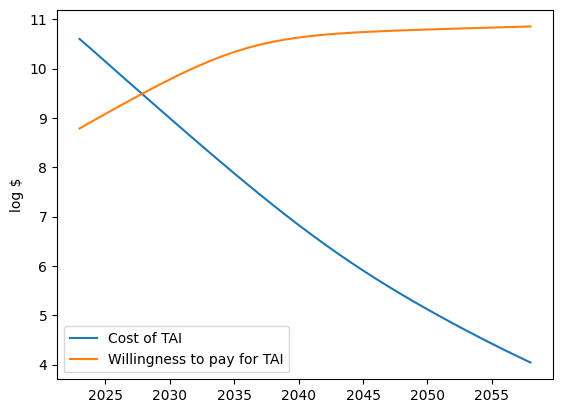

-
-
## SAMPLE RUN 24 ##
It takes 26.8 log FLOP (~631 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.0 years they get 2x cheaper, to a maximum of 21.6 log FLOP (~4 sextillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~193 million). This doubles every 2.2 years to a max of 0.025% of GDP. GDP grows at a rate of 1.02x per year.
---
Year: 2023 - 26.6 max log FLOP (372 septillion) available - TAI takes 26.8 log FLOP (631 septillion) - log $ 8.5 to buy TAI (316 million) vs. willingness to pay log $ 8.3 (187 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.6)
Year: 2024 - 26.9 max log FLOP (712 septillion) available - TAI takes 26.7 log FLOP (507 septillion) - log $ 8.3 to buy TAI (179 million) vs. willingness to pay log $ 8.4 (252 million) - 18.5 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP

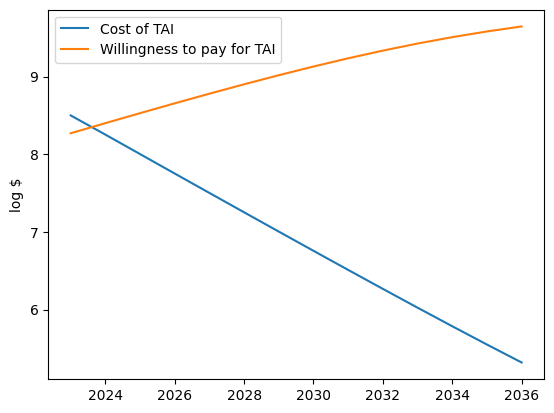

-
-
## SAMPLE RUN 25 ##
It takes 26.9 log FLOP (~794 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.8 years they get 2x cheaper, to a maximum of 23.2 log FLOP (~173 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~247 million). This doubles every 1.0 years until 2025, and then doubles every 0.9 years to a max of 0.059149% of GDP. GDP grows at a rate of 1.029x per year.
---
Year: 2023 - 26.7 max log FLOP (483 septillion) available - TAI takes 26.9 log FLOP (794 septillion) - log $ 8.6 to buy TAI (398 million) vs. willingness to pay log $ 8.4 (242 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.7)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 26.8 log FLOP (638 septillion) - log $ 8.3 to buy TAI (220 million) vs. willingness to pay log $ 8.7 (482 million) - 18.5 log FL

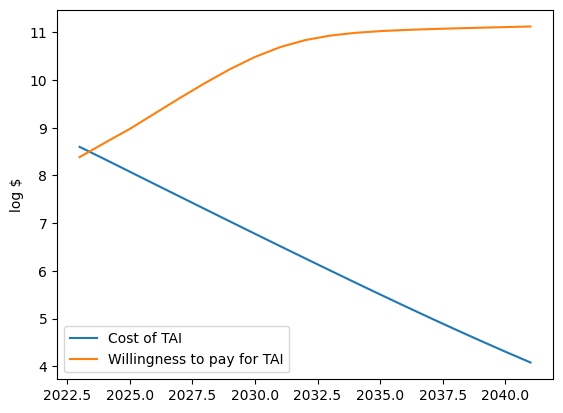

-
-
## SAMPLE RUN 26 ##
It takes 36.5 log FLOP (~3 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.4 years they get 2x cheaper, to a maximum of 22.2 log FLOP (~16 sextillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~717 million). This doubles every 3.8 years to a max of 0.032167% of GDP. GDP grows at a rate of 1.014x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 36.5 log FLOP (3 thousand decillion) - log $ 18.2 to buy TAI (2 quintillion) vs. willingness to pay log $ 8.8 (654 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.1)
Year: 2024 - 27.4 max log FLOP (2 octillion) available - TAI takes 36.2 log FLOP (2 thousand decillion) - log $ 17.7 to buy TAI (489 quadrillion) vs. willingness to pay log $ 8.9 (772 million) - 18.5 log FLOP per $ (3 quintilli

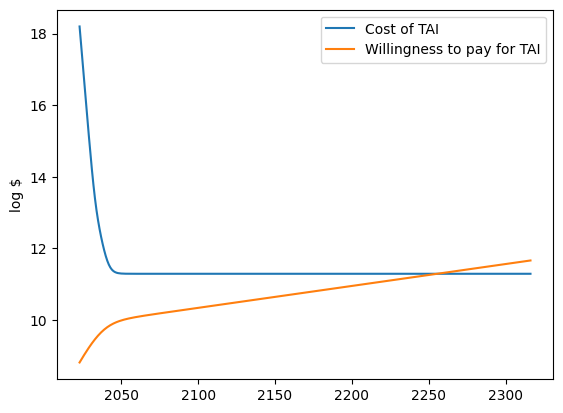

-
-
## SAMPLE RUN 27 ##
It takes 27.1 log FLOP (~1 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 21.9 log FLOP (~8 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~395 million). This doubles every 1.9 years to a max of 0.214324% of GDP. GDP grows at a rate of 1.023x per year.
---
Year: 2023 - 26.9 max log FLOP (782 septillion) available - TAI takes 27.1 log FLOP (1 octillion) - log $ 8.8 to buy TAI (631 million) vs. willingness to pay log $ 8.6 (392 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.9)
Year: 2024 - 27.2 max log FLOP (1 octillion) available - TAI takes 27.0 log FLOP (1 octillion) - log $ 8.6 to buy TAI (383 million) vs. willingness to pay log $ 8.7 (558 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.0)


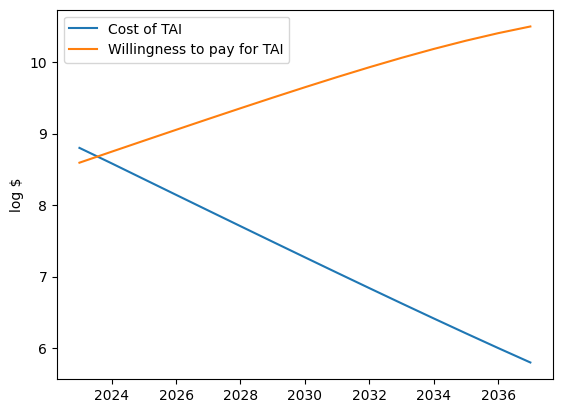

-
-
## SAMPLE RUN 28 ##
It takes 39.7 log FLOP (~5 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.2 years they get 2x cheaper, to a maximum of 24.2 log FLOP (~2 septillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~197 million). This doubles every 2.9 years to a max of 0.082088% of GDP. GDP grows at a rate of 1.031x per year.
---
Year: 2023 - 26.6 max log FLOP (390 septillion) available - TAI takes 39.7 log FLOP (5 million decillion) - log $ 21.4 to buy TAI (3 sextillion) vs. willingness to pay log $ 8.3 (195 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.6)
Year: 2024 - 26.8 max log FLOP (612 septillion) available - TAI takes 39.4 log FLOP (3 million decillion) - log $ 21.0 to buy TAI (1 sextillion) vs. willingness to pay log $ 8.4 (247 million) - 18.4 log FLOP per $ (2 quintillion) 

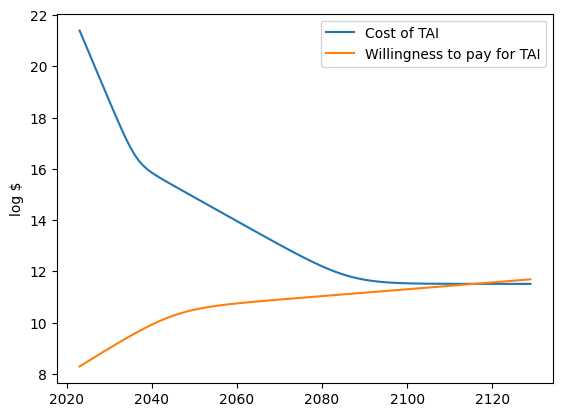

-
-
## SAMPLE RUN 29 ##
It takes 32.0 log FLOP (~100 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 20.8 log FLOP (~604 quintillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~852 million). This doubles every 2.4 years to a max of 0.025% of GDP. GDP grows at a rate of 1.033x per year.
---
Year: 2023 - 27.2 max log FLOP (1 octillion) available - TAI takes 32.0 log FLOP (100 nonillion) - log $ 13.7 to buy TAI (50 trillion) vs. willingness to pay log $ 8.9 (742 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.2)
Year: 2024 - 27.4 max log FLOP (3 octillion) available - TAI takes 31.9 log FLOP (72 nonillion) - log $ 13.4 to buy TAI (27 trillion) vs. willingness to pay log $ 9.0 (958 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 

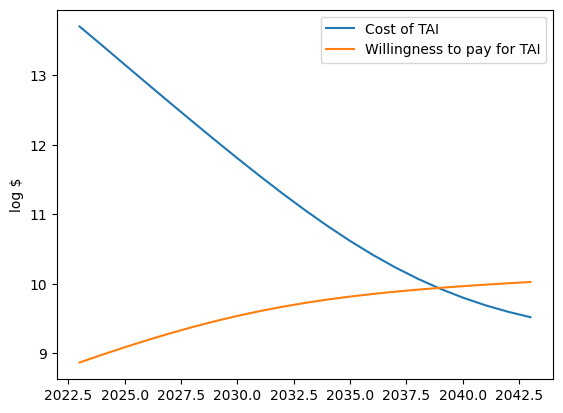

-
-
## SAMPLE RUN 30 ##
It takes 39.0 log FLOP (~1 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 3.3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~7 sextillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~124 million). This doubles every 3.9 years to a max of 0.031168% of GDP. GDP grows at a rate of 1.028x per year.
---
Year: 2023 - 26.4 max log FLOP (243 septillion) available - TAI takes 39.0 log FLOP (1 million decillion) - log $ 20.7 to buy TAI (501 quintillion) vs. willingness to pay log $ 8.1 (122 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.4)
Year: 2024 - 26.6 max log FLOP (398 septillion) available - TAI takes 38.7 log FLOP (501 thousand decillion) - log $ 20.3 to buy TAI (182 quintillion) vs. willingness to pay log $ 8.2 (145 million) - 18.4 log FLOP per $ (3 qu

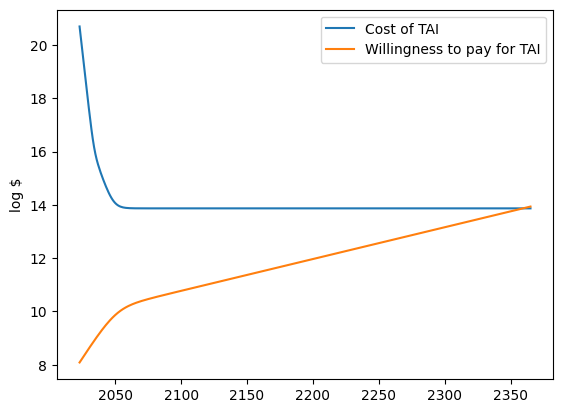

-
-
## SAMPLE RUN 31 ##
It takes 32.5 log FLOP (~316 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~30 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~246 million). This doubles every 2.2 years to a max of 0.048469% of GDP. GDP grows at a rate of 1.035x per year.
---
Year: 2023 - 26.7 max log FLOP (480 septillion) available - TAI takes 32.5 log FLOP (316 nonillion) - log $ 14.2 to buy TAI (158 trillion) vs. willingness to pay log $ 8.4 (240 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.7)
Year: 2024 - 26.9 max log FLOP (870 septillion) available - TAI takes 32.4 log FLOP (227 nonillion) - log $ 13.9 to buy TAI (85 trillion) vs. willingness to pay log $ 8.5 (327 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-

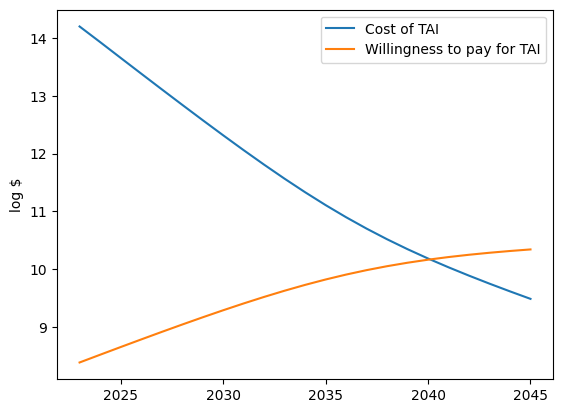

-
-
## SAMPLE RUN 32 ##
It takes 27.2 log FLOP (~2 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.1 years they get 2x cheaper, to a maximum of 20.9 log FLOP (~800 quintillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~198 million). This doubles every 2.0 years to a max of 0.092115% of GDP. GDP grows at a rate of 1.022x per year.
---
Year: 2023 - 26.6 max log FLOP (390 septillion) available - TAI takes 27.2 log FLOP (2 octillion) - log $ 8.9 to buy TAI (796 million) vs. willingness to pay log $ 8.3 (196 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.6)
Year: 2024 - 26.8 max log FLOP (686 septillion) available - TAI takes 27.1 log FLOP (1 octillion) - log $ 8.7 to buy TAI (511 million) vs. willingness to pay log $ 8.4 (275 million) - 18.4 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 

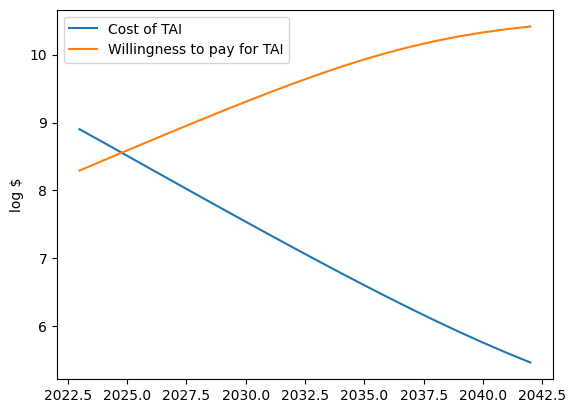

-
-
## SAMPLE RUN 33 ##
It takes 30.6 log FLOP (~4 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.3 years they get 2x cheaper, to a maximum of 24.8 log FLOP (~6 septillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~569 million). This doubles every 3.7 years to a max of 0.025% of GDP. GDP grows at a rate of 1.03x per year.
---
Year: 2023 - 27.0 max log FLOP (1 octillion) available - TAI takes 30.6 log FLOP (4 nonillion) - log $ 12.3 to buy TAI (2 trillion) vs. willingness to pay log $ 8.7 (517 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.0)
Year: 2024 - 27.2 max log FLOP (2 octillion) available - TAI takes 30.5 log FLOP (3 nonillion) - log $ 12.1 to buy TAI (1 trillion) vs. willingness to pay log $ 8.8 (614 million) - 18.4 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.1)
Year:

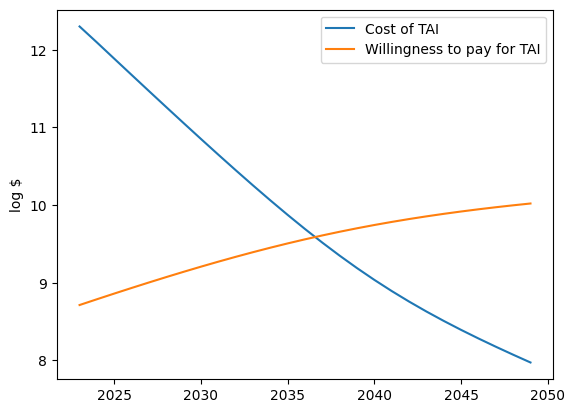

-
-
## SAMPLE RUN 34 ##
It takes 26.5 log FLOP (~316 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 22.9 log FLOP (~85 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~473 million). This doubles every 1.8 years to a max of 0.03707% of GDP. GDP grows at a rate of 1.009x per year.
---
Year: 2023 - 27.0 max log FLOP (895 septillion) available - TAI takes 26.5 log FLOP (316 septillion) - log $ 8.2 to buy TAI (158 million) vs. willingness to pay log $ 8.7 (448 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.0)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- data p_nonscaling_issue p=0.0 -> Nonscaling issue did

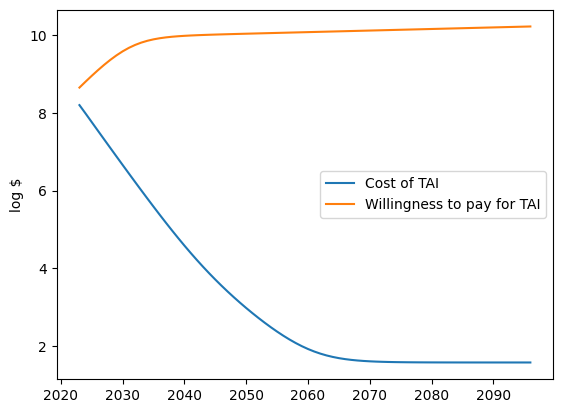

-
-
## SAMPLE RUN 35 ##
It takes 29.6 log FLOP (~398 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.1 years they get 2x cheaper, to a maximum of 22.6 log FLOP (~36 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~461 million). This doubles every 2.1 years to a max of 0.025% of GDP. GDP grows at a rate of 1.007x per year.
---
Year: 2023 - 26.9 max log FLOP (852 septillion) available - TAI takes 29.6 log FLOP (398 octillion) - log $ 11.3 to buy TAI (200 billion) vs. willingness to pay log $ 8.6 (427 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.9)
Year: 2024 - 27.2 max log FLOP (1 octillion) available - TAI takes 29.5 log FLOP (320 octillion) - log $ 11.1 to buy TAI (129 billion) vs. willingness to pay log $ 8.8 (576 million) - 18.4 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP

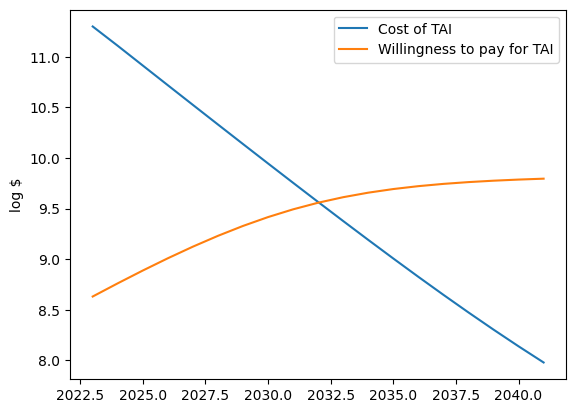

-
-
## SAMPLE RUN 36 ##
It takes 40.6 log FLOP (~40 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.9 years they get 2x cheaper, to a maximum of 25.9 log FLOP (~78 septillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~394 million). This doubles every 1.7 years to a max of 0.161343% of GDP. GDP grows at a rate of 1.021x per year.
---
Year: 2023 - 26.9 max log FLOP (778 septillion) available - TAI takes 40.6 log FLOP (40 million decillion) - log $ 22.3 to buy TAI (20 sextillion) vs. willingness to pay log $ 8.6 (390 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.9)
Year: 2024 - 27.2 max log FLOP (2 octillion) available - TAI takes 40.3 log FLOP (20 million decillion) - log $ 21.8 to buy TAI (7 sextillion) vs. willingness to pay log $ 8.8 (586 million) - 18.5 log FLOP per $ (3 quintillion

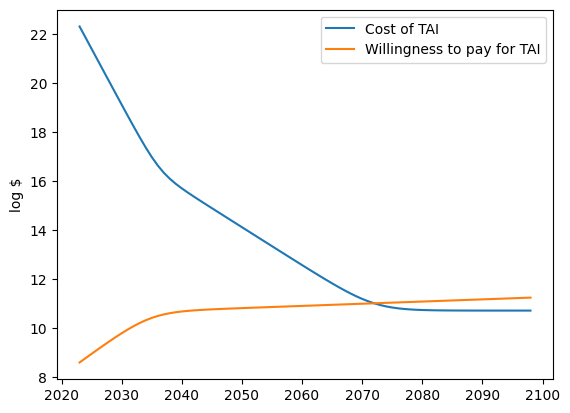

-
-
## SAMPLE RUN 37 ##
It takes 24.9 log FLOP (~8 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 21.3 log FLOP (~2 sextillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~739 million). This doubles every 2.1 years to a max of 0.046222% of GDP. GDP grows at a rate of 1.02x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 24.9 log FLOP (8 septillion) - log $ 6.6 to buy TAI (4 million) vs. willingness to pay log $ 8.8 (691 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.1)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 5 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 6 years)
-- data p_nonscaling_i

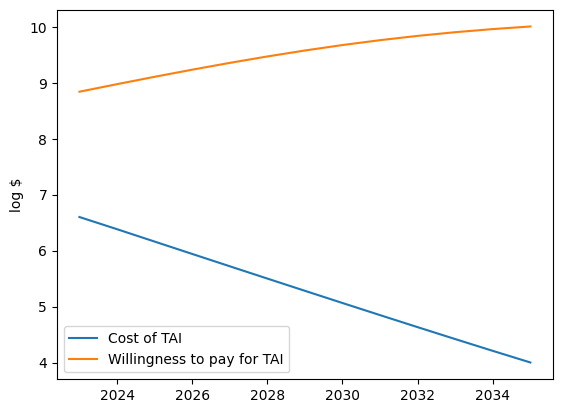

-
-
## SAMPLE RUN 38 ##
It takes 29.9 log FLOP (~794 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 24.3 log FLOP (~2 septillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~593 million). This doubles every 1.0 years until 2025, and then doubles every 0.9 years to a max of 0.042316% of GDP. GDP grows at a rate of 1.019x per year.
---
Year: 2023 - 27.0 max log FLOP (1 octillion) available - TAI takes 29.9 log FLOP (794 octillion) - log $ 11.6 to buy TAI (398 billion) vs. willingness to pay log $ 8.7 (559 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.0)
Year: 2024 - 27.4 max log FLOP (3 octillion) available - TAI takes 29.8 log FLOP (638 octillion) - log $ 11.4 to buy TAI (243 billion) vs. willingness to pay log $ 9.0 (1 billion) - 18.4 log FLOP per

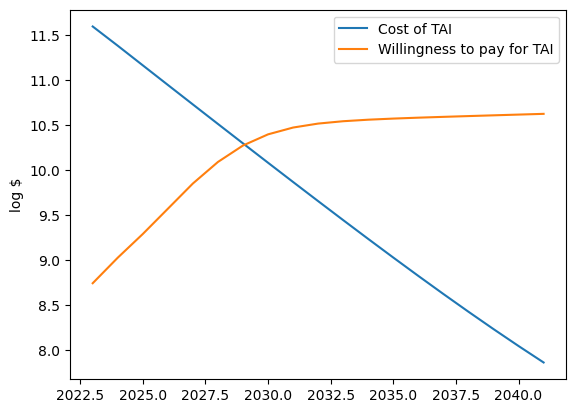

-
-
## SAMPLE RUN 39 ##
It takes 27.5 log FLOP (~3 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 23.9 log FLOP (~858 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~372 million). This doubles every 3.7 years to a max of 0.025% of GDP. GDP grows at a rate of 1.026x per year.
---
Year: 2023 - 26.8 max log FLOP (698 septillion) available - TAI takes 27.5 log FLOP (3 octillion) - log $ 9.2 to buy TAI (2 billion) vs. willingness to pay log $ 8.5 (350 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.0 max log FLOP (1 octillion) available - TAI takes 27.4 log FLOP (3 octillion) - log $ 9.0 to buy TAI (1 billion) vs. willingness to pay log $ 8.6 (417 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 26.9)
Year:

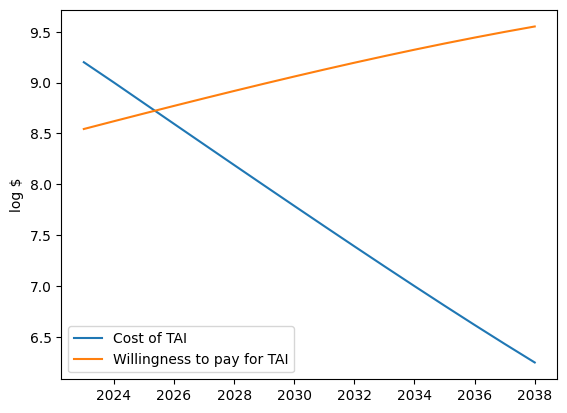

-
-
## SAMPLE RUN 40 ##
It takes 27.7 log FLOP (~5 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 23.6 log FLOP (~443 sextillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~193 million). This doubles every 5.6 years to a max of 0.025% of GDP. GDP grows at a rate of 1.038x per year.
---
Year: 2023 - 26.6 max log FLOP (372 septillion) available - TAI takes 27.7 log FLOP (5 octillion) - log $ 9.4 to buy TAI (3 billion) vs. willingness to pay log $ 8.3 (187 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.6)
Year: 2024 - 26.8 max log FLOP (575 septillion) available - TAI takes 27.6 log FLOP (4 octillion) - log $ 9.2 to buy TAI (1 billion) vs. willingness to pay log $ 8.3 (210 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 26.6)
Ye

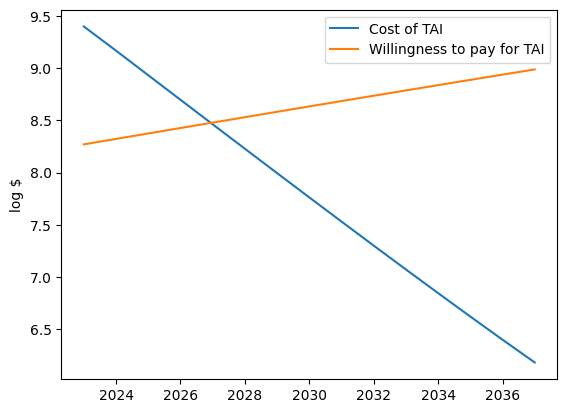

-
-
## SAMPLE RUN 41 ##
It takes 33.8 log FLOP (~6 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 26.0 log FLOP (~91 septillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~314 million). This doubles every 2.2 years to a max of 0.163431% of GDP. GDP grows at a rate of 1.029x per year.
---
Year: 2023 - 26.8 max log FLOP (621 septillion) available - TAI takes 33.8 log FLOP (6 decillion) - log $ 15.5 to buy TAI (3 quadrillion) vs. willingness to pay log $ 8.5 (311 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.0 max log FLOP (1 octillion) available - TAI takes 33.7 log FLOP (5 decillion) - log $ 15.2 to buy TAI (2 quadrillion) vs. willingness to pay log $ 8.6 (425 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLO

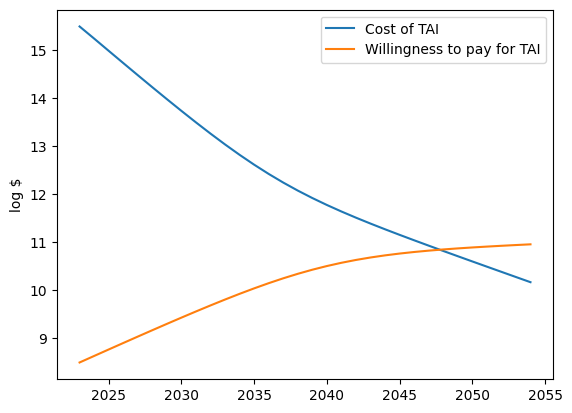

-
-
## SAMPLE RUN 42 ##
It takes 29.0 log FLOP (~100 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.8 years they get 2x cheaper, to a maximum of 24.6 log FLOP (~4 septillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~389 million). This doubles every 2.8 years to a max of 0.075099% of GDP. GDP grows at a rate of 1.029x per year.
---
Year: 2023 - 26.9 max log FLOP (759 septillion) available - TAI takes 29.0 log FLOP (100 octillion) - log $ 10.7 to buy TAI (50 billion) vs. willingness to pay log $ 8.6 (381 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.9)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 28.9 log FLOP (80 octillion) - log $ 10.4 to buy TAI (28 billion) vs. willingness to pay log $ 8.7 (484 million) - 18.5 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP:

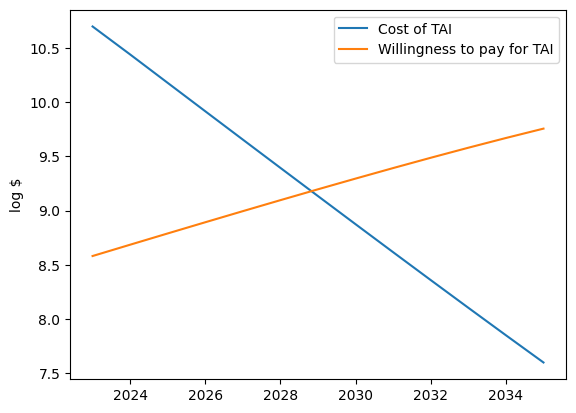

-
-
## SAMPLE RUN 43 ##
It takes 32.1 log FLOP (~126 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 25.1 log FLOP (~12 septillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~374 million). This doubles every 2.2 years to a max of 0.02694% of GDP. GDP grows at a rate of 1.011x per year.
---
Year: 2023 - 26.8 max log FLOP (704 septillion) available - TAI takes 32.1 log FLOP (126 nonillion) - log $ 13.8 to buy TAI (63 trillion) vs. willingness to pay log $ 8.5 (353 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 32.0 log FLOP (90 nonillion) - log $ 13.5 to buy TAI (35 trillion) vs. willingness to pay log $ 8.7 (472 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLO

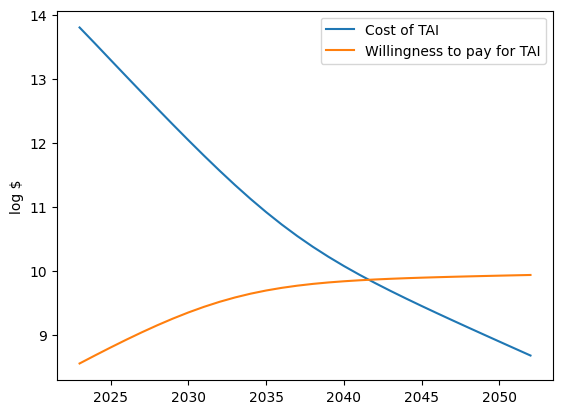

-
-
## SAMPLE RUN 44 ##
It takes 28.0 log FLOP (~10 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 23.2 log FLOP (~142 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~374 million). This doubles every 3.7 years to a max of 0.027185% of GDP. GDP grows at a rate of 1.027x per year.
---
Year: 2023 - 26.8 max log FLOP (705 septillion) available - TAI takes 28.0 log FLOP (10 octillion) - log $ 9.7 to buy TAI (5 billion) vs. willingness to pay log $ 8.5 (353 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 27.9 log FLOP (8 octillion) - log $ 9.5 to buy TAI (3 billion) vs. willingness to pay log $ 8.6 (422 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 26.9

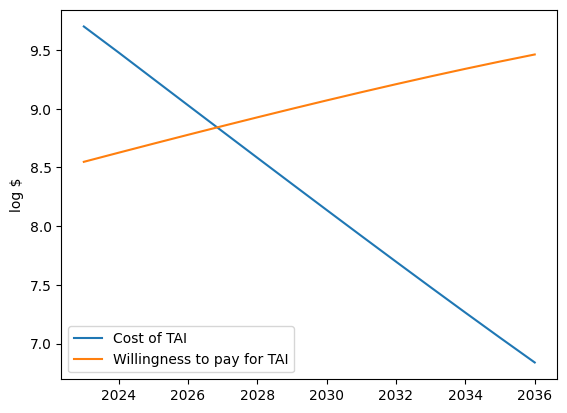

-
-
## SAMPLE RUN 45 ##
It takes 46.1 log FLOP (~13 trillion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 6 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.0 years they get 2x cheaper, to a maximum of 21.6 log FLOP (~4 sextillion) per 2022$USD.
We are initially willing to pay 9.2 log 2022$USD (~1 billion). This doubles every 2.0 years to a max of 0.025% of GDP. GDP grows at a rate of 1.021x per year.
---
Year: 2023 - 27.4 max log FLOP (2 octillion) available - TAI takes 46.1 log FLOP (13 trillion decillion) - log $ 27.8 to buy TAI (6 octillion) vs. willingness to pay log $ 9.1 (1 billion) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.4)
Year: 2024 - 27.6 max log FLOP (4 octillion) available - TAI takes 45.8 log FLOP (6 trillion decillion) - log $ 27.4 to buy TAI (2 octillion) vs. willingness to pay log $ 9.2 (2 billion) - 18.4 log FLOP per $ (3 quintillion) (Effective 2

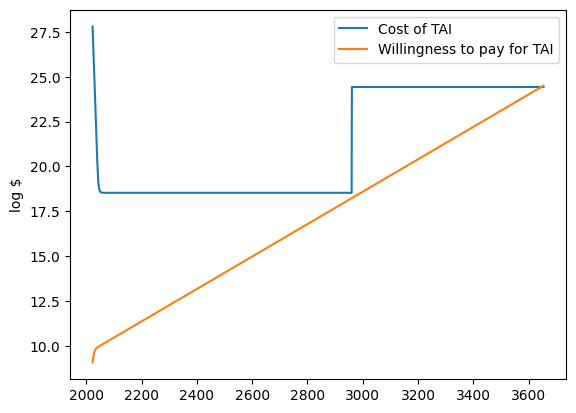

-
-
## SAMPLE RUN 46 ##
It takes 30.3 log FLOP (~2 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.5 years they get 2x cheaper, to a maximum of 24.3 log FLOP (~2 septillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~861 million). This doubles every 1.0 years until 2025, and then doubles every 0.9 years to a max of 0.02692% of GDP. GDP grows at a rate of 1.032x per year.
---
Year: 2023 - 27.2 max log FLOP (2 octillion) available - TAI takes 30.3 log FLOP (2 nonillion) - log $ 12.0 to buy TAI (1 trillion) vs. willingness to pay log $ 8.9 (756 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.2)
Year: 2024 - 27.5 max log FLOP (3 octillion) available - TAI takes 30.2 log FLOP (2 nonillion) - log $ 11.8 to buy TAI (628 billion) vs. willingness to pay log $ 9.1 (1 billion) - 18.4 log FLOP per $ (2 qu

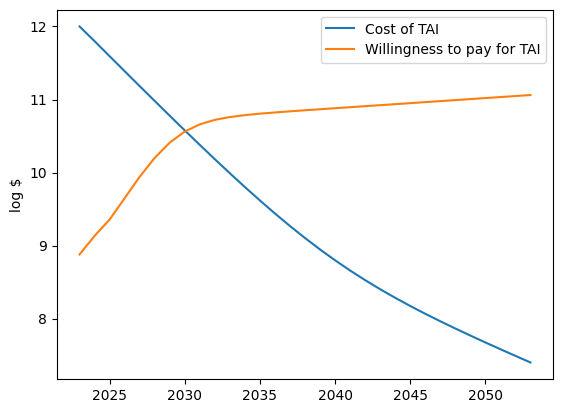

-
-
## SAMPLE RUN 47 ##
It takes 24.4 log FLOP (~3 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 4.0 years they get 2x cheaper, to a maximum of 24.7 log FLOP (~5 septillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~470 million). This doubles every 2.9 years to a max of 0.033115% of GDP. GDP grows at a rate of 1.021x per year.
---
Year: 2023 - 26.9 max log FLOP (884 septillion) available - TAI takes 24.4 log FLOP (3 septillion) - log $ 6.1 to buy TAI (1 million) vs. willingness to pay log $ 8.6 (443 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.9)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 5 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 6 years)
-- data p_nonscali

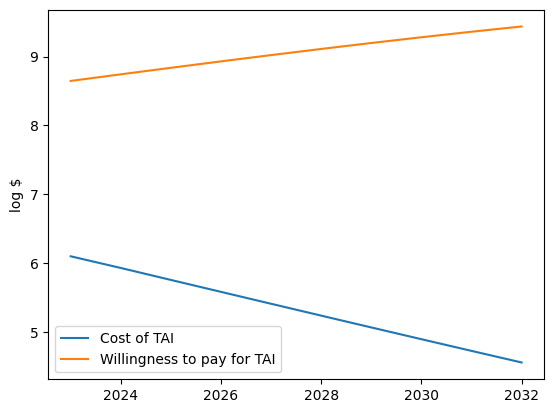

-
-
## SAMPLE RUN 48 ##
It takes 26.7 log FLOP (~501 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 22.0 log FLOP (~10 sextillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~605 million). This doubles every 1.2 years to a max of 0.063948% of GDP. GDP grows at a rate of 1.019x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 26.7 log FLOP (501 septillion) - log $ 8.4 to buy TAI (251 million) vs. willingness to pay log $ 8.8 (581 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.1)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling delay occured
-- -- this delay is 7 years (total delay 7 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 7 years)
-- data p_nons

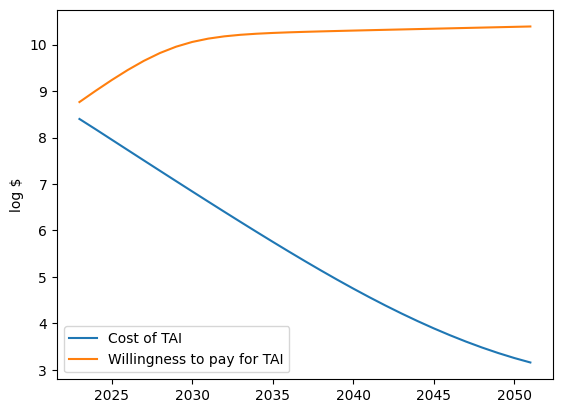

-
-
## SAMPLE RUN 49 ##
It takes 40.9 log FLOP (~79 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.1 years they get 2x cheaper, to a maximum of 26.1 log FLOP (~139 septillion) per 2022$USD.
We are initially willing to pay 9.4 log 2022$USD (~3 billion). This doubles every 3.2 years to a max of 0.025% of GDP. GDP grows at a rate of 1.018x per year.
---
Year: 2023 - 27.6 max log FLOP (4 octillion) available - TAI takes 40.9 log FLOP (79 million decillion) - log $ 22.6 to buy TAI (40 sextillion) vs. willingness to pay log $ 9.3 (2 billion) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.6)
Year: 2024 - 27.8 max log FLOP (6 octillion) available - TAI takes 40.6 log FLOP (40 million decillion) - log $ 22.2 to buy TAI (14 sextillion) vs. willingness to pay log $ 9.3 (2 billion) - 18.4 log FLOP per $ (3 quintillion) (Effecti

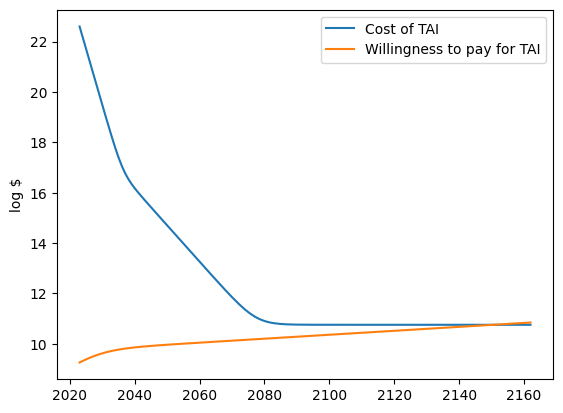

-
-
## SAMPLE RUN 50 ##
It takes 26.1 log FLOP (~126 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.8 years they get 2x cheaper, to a maximum of 26.8 log FLOP (~633 septillion) per 2022$USD.
We are initially willing to pay 9.0 log 2022$USD (~1 billion). This doubles every 1.8 years to a max of 0.027385% of GDP. GDP grows at a rate of 1.02x per year.
---
Year: 2023 - 27.3 max log FLOP (2 octillion) available - TAI takes 26.1 log FLOP (126 septillion) - log $ 7.8 to buy TAI (63 million) vs. willingness to pay log $ 9.0 (899 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.3)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 3 years)
-- data p_nonscal

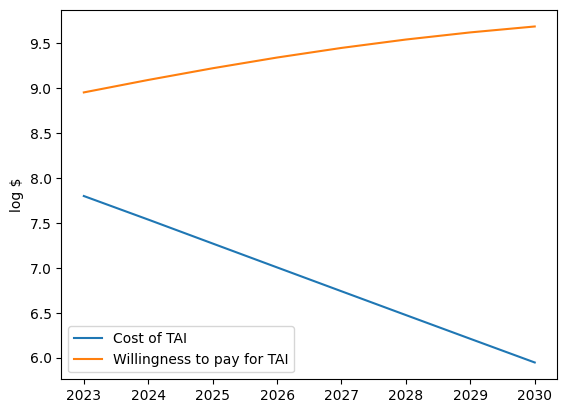

-
-
## SAMPLE RUN 51 ##
It takes 30.8 log FLOP (~6 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 21.6 log FLOP (~4 sextillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~195 million). This doubles every 4.2 years to a max of 0.041221% of GDP. GDP grows at a rate of 1.02x per year.
---
Year: 2023 - 26.6 max log FLOP (382 septillion) available - TAI takes 30.8 log FLOP (6 nonillion) - log $ 12.5 to buy TAI (3 trillion) vs. willingness to pay log $ 8.3 (191 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.6)
Year: 2024 - 26.8 max log FLOP (578 septillion) available - TAI takes 30.7 log FLOP (5 nonillion) - log $ 12.3 to buy TAI (2 trillion) vs. willingness to pay log $ 8.4 (225 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 26

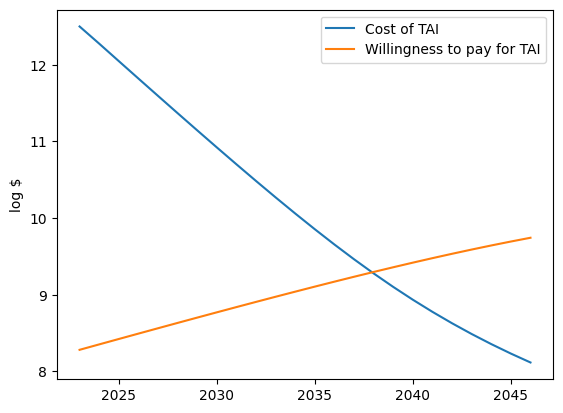

-
-
## SAMPLE RUN 52 ##
It takes 26.8 log FLOP (~631 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.1 years they get 2x cheaper, to a maximum of 23.1 log FLOP (~133 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~300 million). This doubles every 3.4 years to a max of 0.025845% of GDP. GDP grows at a rate of 1.017x per year.
---
Year: 2023 - 26.8 max log FLOP (570 septillion) available - TAI takes 26.8 log FLOP (631 septillion) - log $ 8.5 to buy TAI (316 million) vs. willingness to pay log $ 8.5 (286 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.0 max log FLOP (958 septillion) available - TAI takes 26.7 log FLOP (507 septillion) - log $ 8.3 to buy TAI (183 million) vs. willingness to pay log $ 8.5 (346 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-l

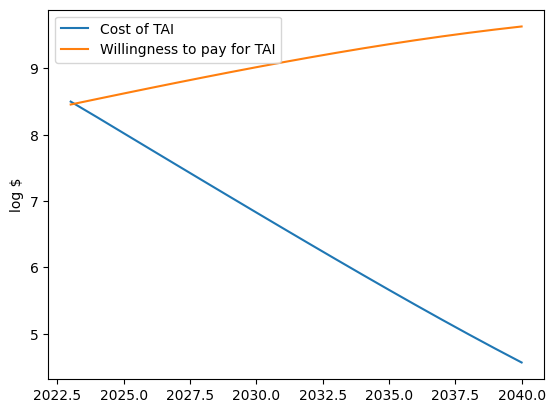

-
-
## SAMPLE RUN 53 ##
It takes 31.5 log FLOP (~32 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.6 years they get 2x cheaper, to a maximum of 22.8 log FLOP (~58 sextillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~619 million). This doubles every 1.7 years to a max of 0.147811% of GDP. GDP grows at a rate of 1.014x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 31.5 log FLOP (32 nonillion) - log $ 13.2 to buy TAI (16 trillion) vs. willingness to pay log $ 8.8 (608 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.1)
Year: 2024 - 27.3 max log FLOP (2 octillion) available - TAI takes 31.4 log FLOP (24 nonillion) - log $ 13.0 to buy TAI (10 trillion) vs. willingness to pay log $ 9.0 (911 million) - 18.4 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 2

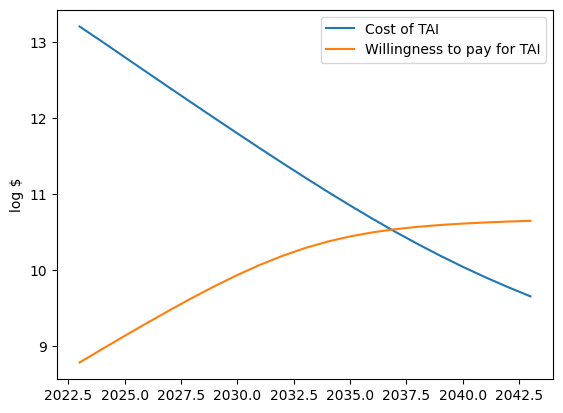

In [10]:
for i in range(50):
    print('-')
    print('-')
    print('## SAMPLE RUN {} ##'.format(i + 3 + 1))
    define_tai_timeline_event(variables, verbose=True)

In [11]:
print('File last ran: {}'.format(dt.now()))

File last ran: 2023-07-09 16:24:48.675350
